# LA Traffic - Final Project

*   IST 652
*   Authors: Prasad Kulkarni, Sathish Kumar Rajediran
*   Final Project
*   Date: September 2,2020




# Introduction

As the second largest city in the United States, Los Angeles has traffic challenges due to a large and growing population and an increase in the number of cars. A better understanding of the factors that contribute to accidents can help government officials, companies, citizens and other interested parties to understand how to make the city safer and more drivable.

The goal is to explore the trends and correlations between the data to provide useful information such as the most dangerous intersections, best/worst times of the day for accidents and other useful information.

# Analysis Questions and Sources


To guide our analysis we came up with a bunch of questions to answer in our analysis:

What are the most dangerous streets?  

What are the most common collision areas in Los Angeles? 

What are the best/worst days of the week for accidents? Month? 

## Sources

### Traffic dataset
The Los Angeles Traffic Collision Data is publicly available from Kaggle.com is owned by the City of Los Angeles. The dataset contains 481,568 incidents from 2010 to 2019
https://www.kaggle.com/cityofLA/los-angeles-traffic-collision-data

### Median Income dataset
This Dataset is mainly for future use during detailed project analysis. For Median Income, incomes were pulled from the LA Chamber of Commerce website. They were then inputted into a CSV and merged into the original data frame.
https://lachamber.com/clientuploads/pdf/2018/18_BeaconReport_LR.pdf

### Twitter dataset
Using GetOldTweets3 (python library), import tweets between 2010 to 2019 with search keywords including #latraffic, #losangeles, #lapd to correlate LA road traffic collisions and their trend analysis from social media tweets. Here, trend in tweets are correlated directly to the number of accidents/collisions reported on Kaggle’s collision dataset.

## Process flow
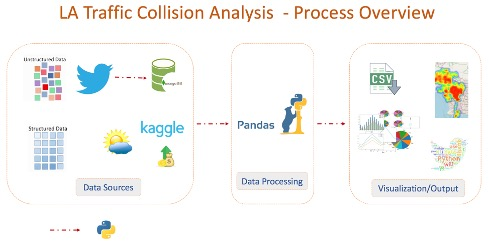

# Loading and Cleaning the Data

## Data Cleaning
* Blank values and NAs were removed with the dropna() function.
* Time Occurred column was broken up into hours into a hours column
* Date was converted to DateTime and broken up into months, weekdays, and year columns.
* Year subsets were created in order to give flexibility to analyze any given year (la_2017 and la_2018 were concatenated and used to filter main dataset to show only data from 2017 and 2018)
* Location was broken up into longitude and latitude columns to make it easier to analyze with map visualizations.
* Date Occurred was dropped as well.

In [4]:
# pip install tweepy
# !pip install GetOldTweets3
# !pip install folium

In [6]:
# ***********************************************************************************
#      import libraries
# ***********************************************************************************

# standard library
import os
import sys
from datetime import datetime
import calendar
import time
import ast
import re
import timeit
import requests

# csv, xls, pandas & json
import pandas as pd
import json
import csv
import xlrd
import numpy as np

#twitter libraries
import GetOldTweets3 as got
import preprocessor as p
    
#MongoDB libraries
import pymongo
from pymongo import MongoClient

#visualization
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager
import plotly.graph_objs as go
import plotly.offline as offline
from PIL import Image
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
import matplotlib.ticker as ticker
import folium
from folium.plugins import HeatMap
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
%matplotlib inline

print('Libraries imported successfully!\n')
os.getcwd()

Libraries imported successfully!



'/Users/prasadkulkarni/Documents/Syracuse University/IST 652/Assignments/Project/Final Submission'

In [ ]:
# INSTANT CLEAN 
# run this to get cleaned dataset

# import pandas as pd
# import numpy as np
# import requests
# import ast
# import plotly
# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib
# import datetime
# import calendar
# import plotly.graph_objs as go
# import plotly.offline as offline
# from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from matplotlib.dates import AutoDateFormatter, AutoDateLocator
# import matplotlib.ticker as ticker
# import folium
# from folium.plugins import HeatMap



In [7]:
# Theme and styles for visuals
matplotlib.rcParams['font.family'] = "serif" # font
sns.set_context('talk') # visuals outputted for presentation style
plt.style.use('ggplot')
print('Theme has been setup successfully!\n')

Theme has been setup successfully!



In [8]:
#Read in the csv with the LA traffic data from 2010-2019

# Working with file
try: 
    la = pd.read_csv("traffic-collision-data-from-2010-to-present.csv")
#     print("data has been processed \n")
except:
    print("Is the file in correct directory?")
    
# add income and clean

try: 
    income = pd.read_csv("LAIncomeCouncil.csv")
#     print("data has been processed \n")
except:
    print("Is the file in correct directory?")



# Clean income for calculations and make float type
income["Median Income"] = income["Median Income"].str.replace(",","")
income["Median Income"] = income["Median Income"].str.replace(" ","")
income["Median Income"] = income["Median Income"].str.replace('$','')
income['Median Income'].astype(float)

# merge income into LA dataset using the common column of Council Districts
la = la.merge(income, how = 'inner', on = ['Council Districts'])

# drop columns not used in project
la.drop(["DR Number", 
         "Area ID", 
         "Crime Code", 
         "Crime Code Description",
         "Premise Code",
         "Precinct Boundaries",
         "Date Reported", 
         "Neighborhood Councils (Certified)", 
         "Census Tracts", 
         "MO Codes", 
         "LA Specific Plans",
        "Reporting District"],
        axis=1, inplace=True)

# drop NAs in dataset
la.dropna(inplace=True)

# Victim Age needs to be integer
la['Victim Age'] = la['Victim Age'].astype(int)

# Zip Codes needs to be string
la['Zip Codes'] = la['Zip Codes'].astype(int).astype(str)

# Median Income needs to be float
la['Median Income'] = la['Median Income'].astype(float)

# Council District needs to be integer
la['Council Districts'] = la['Council Districts'].astype(int)

# Handling Date
# format date and time
la['Date'] =  pd.to_datetime(la['Date Occurred'],format='%Y/%m/%d')
# break up date to allow more variables for comparison
la['year'] = pd.DatetimeIndex(la['Date']).year # adds years column
la['month'] = pd.DatetimeIndex(la['Date']).month # adds month column
la['weekday']= pd.DatetimeIndex(la['Date']).dayofweek # adds weekday column
la['weekday'] = la['Date'].dt.day_name() #make it more readable

# break up by year subsets
la_2015 = la[la['year']== 2015]
la_2016 = la[la['year'] == 2016]
la_2017 = la[la['year'] == 2017]
la_2018 = la[la['year'] == 2018]
la_2019 = la[la['year'] == 2019]

frames = [la_2017, la_2018]
la = pd.concat(frames)

# Handling time, getting hours
la["Time Occurred"] = la["Time Occurred"].astype(str)
la["Time Occurred"] = [i[:2] if len(i) == 4 else i[0] for i in la["Time Occurred"]]
la["Time Occurred"] = la["Time Occurred"].astype(int)
la['hours'] = la['Time Occurred'] # adds hours column

# handling location column, break up into lat and long columns
la['Location'] = [ast.literal_eval(x) for x in la.Location]
la['longitude'] = [x['longitude'] for x in la.Location] # adds longitude column
la['latitude'] = [x['latitude'] for x in la.Location] # adds latitude column
la.longitude = la.longitude.astype(float)
la.latitude = la.latitude.astype(float)

# drop more columns not needed
la = la.drop(['Date Occurred'],axis=1)


# show final rows and columns for dataset, should now be 90845 rows and 19 columns
dataframe_rows, dataframe_cols = la.shape
print("The dimensions of the cleaned Los Angeles Collision dataset is",dataframe_rows,"rows and",dataframe_cols,"columns.")

The dimensions of the cleaned Los Angeles Collision dataset is 90845 rows and 19 columns.


In [9]:
# confirm years of data are in scope of 2017 and 2018
la.year.unique()

array([2017, 2018])

# Data Dictionary

A data dictionary with column names, description, data types, and processing steps is below. After everything was merged and cleaned, the final LA collision dataset for analysis had 90,845 rows and 19 columns.

In [10]:
# confirm data types are changed to desired type
la.dtypes

Time Occurred                   int64
Area Name                      object
Victim Age                      int64
Victim Sex                     object
Victim Descent                 object
Premise Description            object
Address                        object
Cross Street                   object
Location                       object
Zip Codes                      object
Council Districts               int64
Median Income                 float64
Date                   datetime64[ns]
year                            int64
month                           int64
weekday                        object
hours                           int64
longitude                     float64
latitude                      float64
dtype: object

In [11]:
# confirm there are no NULL values in cleaned dataset
pd.isnull(la).sum()

Time Occurred          0
Area Name              0
Victim Age             0
Victim Sex             0
Victim Descent         0
Premise Description    0
Address                0
Cross Street           0
Location               0
Zip Codes              0
Council Districts      0
Median Income          0
Date                   0
year                   0
month                  0
weekday                0
hours                  0
longitude              0
latitude               0
dtype: int64

# Data Summary

In [12]:
la.head() #show final dataset rows

,Time Occurred,Area Name,Victim Age,Victim Sex,Victim Descent,Premise Description,Address,Cross Street,Location,Zip Codes,Council Districts,Median Income,Date,year,month,weekday,hours,longitude,latitude
4920,13,Devonshire,74,F,A,STREET,NORDHOFF ST,LOUISE AV,"{'longitude': '-118.5113', 'human_address': '{...",18514,2,61000.0,2017-12-31,2017,12,Sunday,13,-118.5113,34.2359
4921,21,Devonshire,21,M,B,STREET,BALBOA BL,CHATSWORTH ST,"{'longitude': '-118.5023', 'human_address': '{...",19329,2,61000.0,2017-12-31,2017,12,Sunday,21,-118.5023,34.2648
4922,23,Devonshire,31,M,O,STREET,ZELZAH AV,TRIBUNE ST,"{'longitude': '-118.5234', 'human_address': '{...",19329,2,61000.0,2017-12-31,2017,12,Sunday,23,-118.5234,34.2686
4923,6,West Valley,54,M,O,STREET,SATICOY ST,RESEDA BL,"{'longitude': '-118.536', 'human_address': '{""...",18909,2,61000.0,2017-12-31,2017,12,Sunday,6,-118.5360,34.2084
4924,12,Topanga,28,M,W,STREET,PLATT AV,VICTORY BL,"{'longitude': '-118.6426', 'human_address': '{...",4283,2,61000.0,2017-12-30,2017,12,Saturday,12,-118.6426,34.1898


In [13]:
summary = la.describe()
summary = summary.transpose()
print(summary)

                     count          mean           std         min  \
Time Occurred      90845.0     13.536133      5.589630      1.0000   
Victim Age         90845.0     41.809720     16.156667     15.0000   
Council Districts  90845.0      8.344202      4.175006      1.0000   
Median Income      90845.0  56101.622544  16238.089311  33300.0000   
year               90845.0   2017.502515      0.499996   2017.0000   
month              90845.0      6.560262      3.440489      1.0000   
hours              90845.0     13.536133      5.589630      1.0000   
longitude          90845.0   -118.363911      0.105470   -118.6667   
latitude           90845.0     34.083449      0.108968     33.7070   

                          25%         50%         75%         max  
Time Occurred          9.0000     14.0000     18.0000     23.0000  
Victim Age            29.0000     39.0000     52.0000     99.0000  
Council Districts      5.0000      9.0000     12.0000     15.0000  
Median Income      45300.00

# Loading Additional Weather Data

In [14]:
#Read in the csv with the LA weather data from 2017-2018
try: 
    weather2017 = pd.read_csv('2017weather.csv')
#     print("data has been processed \n")
except:
    print("Is the file in correct directory?")
    
try: 
    weather2018 = pd.read_csv('2018weather_clean2.csv')
#     print("data has been processed \n")
except:
    print("Is the file in correct directory?")
    
weather = pd.concat([weather2017, weather2018])
weather['Date'] =  pd.to_datetime(weather['Date'])

In [15]:
weather.head()

,Unnamed: 0,Date,HighTemp,LowTemp,AverageTemp,Precipitation,NauticalTwilightRise,NauticalTwilightSet
0,0,2017-01-01,55,39,47,0.00,6:01,5:54
1,1,2017-01-02,54,48,51,0.00,6:01,5:55
2,2,2017-01-03,55,45,50,0.00,6:01,5:56
3,3,2017-01-04,57,46,52,0.07,6:02,5:57
4,4,2017-01-05,61,52,56,0.31,6:02,5:57


In [16]:
weather.columns # need to get rid of Unnamed column

Index(['Unnamed: 0', 'Date', 'HighTemp', 'LowTemp', 'AverageTemp',
       'Precipitation', 'NauticalTwilightRise', 'NauticalTwilightSet'],
      dtype='object')

In [17]:
#Merge the la and weather dataframes on date
laWeather = la.merge(weather, how = 'inner', on = ['Date'])

# make new column for rain or not; this will allow us to do comparisons between days with rain and without
laWeather['rain'] = np.where(laWeather['Precipitation']>0, 'yes', 'no')

laWeather.drop(["Unnamed: 0", "Location"], axis= 1, inplace=True) #drop not needed columns


# show final rows and columns for dataset, should be 89381 rows and 25 columns
dataframe_rows, dataframe_cols = laWeather.shape
print("The dimensions of the cleaned Los Angeles Collision Weather dataset is",dataframe_rows,"rows and",dataframe_cols,"columns.")

The dimensions of the cleaned Los Angeles Collision Weather dataset is 89381 rows and 25 columns.


In [18]:
laWeather.head()

,Time Occurred,Area Name,Victim Age,Victim Sex,Victim Descent,Premise Description,Address,Cross Street,Zip Codes,Council Districts,...,hours,longitude,latitude,HighTemp,LowTemp,AverageTemp,Precipitation,NauticalTwilightRise,NauticalTwilightSet,rain
0,13,Devonshire,74,F,A,STREET,NORDHOFF ST,LOUISE AV,18514,2,...,13,-118.5113,34.2359,70,48,59,0.0,6:01,5:54,no
1,21,Devonshire,21,M,B,STREET,BALBOA BL,CHATSWORTH ST,19329,2,...,21,-118.5023,34.2648,70,48,59,0.0,6:01,5:54,no
2,23,Devonshire,31,M,O,STREET,ZELZAH AV,TRIBUNE ST,19329,2,...,23,-118.5234,34.2686,70,48,59,0.0,6:01,5:54,no
3,6,West Valley,54,M,O,STREET,SATICOY ST,RESEDA BL,18909,2,...,6,-118.5360,34.2084,70,48,59,0.0,6:01,5:54,no
4,8,Hollywood,46,F,W,STREET,SUNSET BL,HIGHLAND AV,23446,8,...,8,-118.3405,34.0980,70,48,59,0.0,6:01,5:54,no


In [19]:
laWeather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89381 entries, 0 to 89380
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Time Occurred         89381 non-null  int64         
 1   Area Name             89381 non-null  object        
 2   Victim Age            89381 non-null  int64         
 3   Victim Sex            89381 non-null  object        
 4   Victim Descent        89381 non-null  object        
 5   Premise Description   89381 non-null  object        
 6   Address               89381 non-null  object        
 7   Cross Street          89381 non-null  object        
 8   Zip Codes             89381 non-null  object        
 9   Council Districts     89381 non-null  int64         
 10  Median Income         89381 non-null  float64       
 11  Date                  89381 non-null  datetime64[ns]
 12  year                  89381 non-null  int64         
 13  month           

In [20]:
# confirm there are no NULL values in cleaned weather dataset
pd.isnull(laWeather).sum()

Time Occurred           0
Area Name               0
Victim Age              0
Victim Sex              0
Victim Descent          0
Premise Description     0
Address                 0
Cross Street            0
Zip Codes               0
Council Districts       0
Median Income           0
Date                    0
year                    0
month                   0
weekday                 0
hours                   0
longitude               0
latitude                0
HighTemp                0
LowTemp                 0
AverageTemp             0
Precipitation           0
NauticalTwilightRise    0
NauticalTwilightSet     0
rain                    0
dtype: int64

# Analysis: Weather

In [21]:
# a weather correlation matrix was created to see what kind of relationships each variable had with one another

corr = laWeather.corr()
corr.style.background_gradient(cmap='coolwarm')

,Time Occurred,Victim Age,Council Districts,Median Income,year,month,hours,longitude,latitude,HighTemp,LowTemp,AverageTemp,Precipitation
Time Occurred,1.000000,-0.034761,-0.007412,0.002795,-0.006424,0.003049,1.000000,-0.013264,0.005389,0.010118,0.004748,0.008515,-0.004138
Victim Age,-0.034761,1.000000,-0.024268,0.014912,0.008024,-0.000950,-0.034761,-0.042210,0.015093,-0.008619,-0.010500,-0.010057,0.005318
Council Districts,-0.007412,-0.024268,1.000000,-0.238213,-0.013783,-0.001538,-0.007412,0.696030,-0.899175,0.003631,0.002949,0.003542,-0.009314
Median Income,0.002795,0.014912,-0.238213,1.000000,0.008785,-0.000352,0.002795,-0.320197,0.358039,0.000770,0.001625,0.001195,0.008258
year,-0.006424,0.008024,-0.013783,0.008785,1.000000,-0.003860,-0.006424,-0.012732,0.012887,-0.070220,-0.044303,-0.062358,0.030117
month,0.003049,-0.000950,-0.001538,-0.000352,-0.003860,1.000000,0.003049,-0.003051,0.001215,0.309216,0.244934,0.301942,-0.132701
hours,1.000000,-0.034761,-0.007412,0.002795,-0.006424,0.003049,1.000000,-0.013264,0.005389,0.010118,0.004748,0.008515,-0.004138
longitude,-0.013264,-0.042210,0.696030,-0.320197,-0.012732,-0.003051,-0.013264,1.000000,-0.616481,-0.000835,0.000315,-0.000357,-0.001758
latitude,0.005389,0.015093,-0.899175,0.358039,0.012887,0.001215,0.005389,-0.616481,1.000000,-0.005135,-0.002904,-0.004456,0.012324
HighTemp,0.010118,-0.008619,0.003631,0.000770,-0.070220,0.309216,0.010118,-0.000835,-0.005135,1.000000,0.752336,0.951599,-0.294088


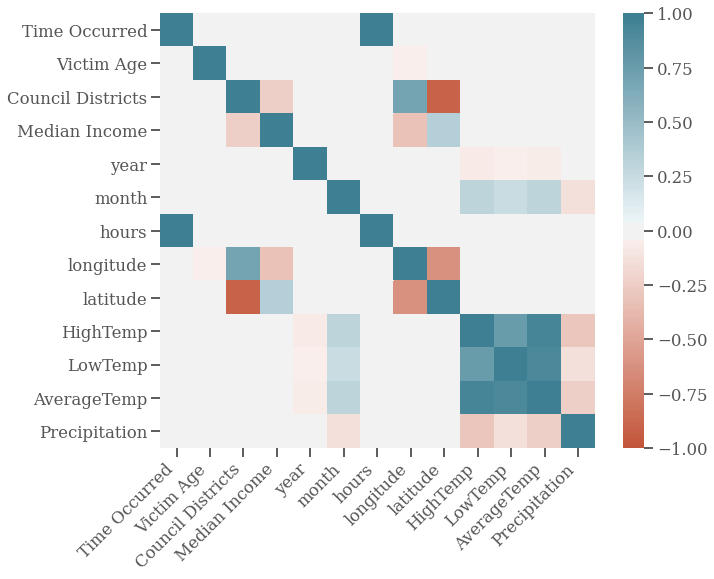

In [22]:
# weather correlation matrix 2
fig,ax = plt.subplots(figsize=(10,8))
corr = laWeather.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

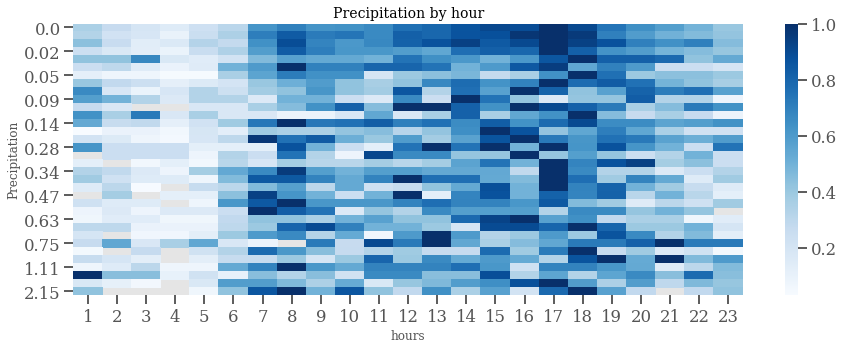

In [23]:
# precipitation by hour heatmap
#x = ['1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm', '12am']
rain_hour_pt = laWeather.pivot_table(index='Precipitation', columns='hours', aggfunc='size')
rain_hour_pt = rain_hour_pt.apply(lambda x: x / rain_hour_pt.max(axis=1))
plt.figure(figsize=(15,5))
plt.title('Precipitation by hour', fontsize=14)
#plt.xlabel('x')
sns.heatmap(rain_hour_pt, cbar=True, annot=False, fmt=".0f", cmap="Blues");

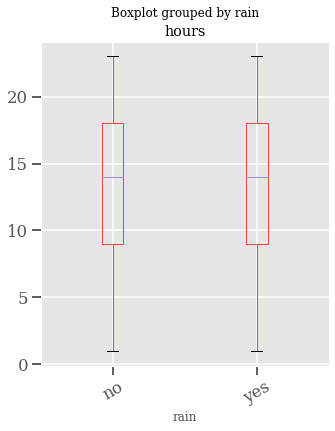

In [24]:
# boxplot showing hours of day collisions with rain or not, time of day most collisions occurs seems to be same, near 3pm average regardless
laWeather.boxplot('hours', 'rain', rot = 30,figsize=(5,6))

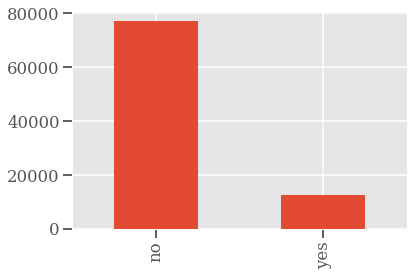

In [25]:
# rainy days vs dry days

laWeather['rain'].value_counts().plot(kind='bar')

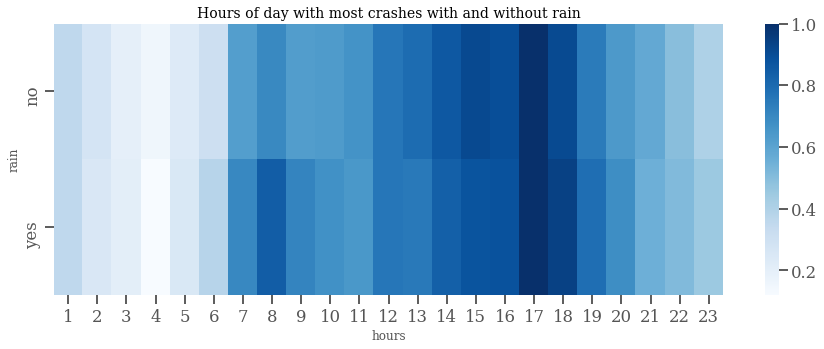

In [26]:
# hours of day with most crashes with and without rain
rain_hour_pt = laWeather.pivot_table(index='rain', columns='hours', aggfunc='size')
rain_hour_pt = rain_hour_pt.apply(lambda x: x / rain_hour_pt.max(axis=1))
plt.figure(figsize=(15,5))
plt.title('Hours of day with most crashes with and without rain', fontsize=14)
sns.heatmap(rain_hour_pt, cbar=True, annot=False, fmt=".0f", cmap="Blues");

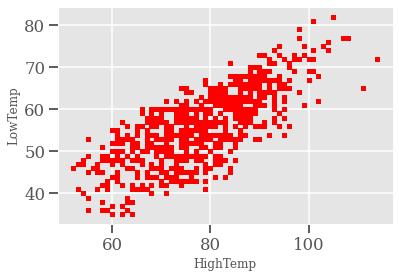

In [27]:
# Import matpolotlib for visualizations
#import matplotlib.pyplot as plt

plt.close('all')
laWeather.plot(kind='scatter',x='HighTemp',y='LowTemp',color='red')
plt.show()

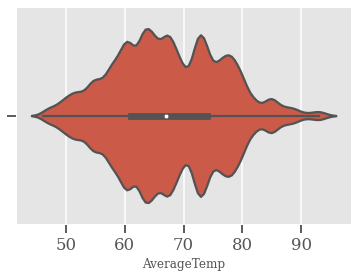

In [28]:
# average temp distribution

sns.violinplot(x='AverageTemp', data=laWeather)

In [29]:
# average temp
laWeather['AverageTemp'].mean()

67.46490864948926

In [30]:
# rainy day analysis

rainydays = laWeather[laWeather['rain']== "yes"]
rainydays.head()

,Time Occurred,Area Name,Victim Age,Victim Sex,Victim Descent,Premise Description,Address,Cross Street,Zip Codes,Council Districts,...,hours,longitude,latitude,HighTemp,LowTemp,AverageTemp,Precipitation,NauticalTwilightRise,NauticalTwilightSet,rain
1217,19,Devonshire,77,M,A,STREET,DEVONSHIRE ST,E HASKELL AV,19329,2,...,19,-118.4761,34.2574,59,42,51,1.000000e-16,5:57,5:47,yes
1218,9,Devonshire,63,M,W,STREET,CHATSWORTH ST,TOPANGA CANYON BL,4284,2,...,9,-118.6061,34.2645,59,42,51,1.000000e-16,5:57,5:47,yes
1219,13,Devonshire,47,F,H,STREET,RESEDA BL,SAN FERNANDO MISSION BL,18905,2,...,13,-118.5361,34.2718,59,42,51,1.000000e-16,5:57,5:47,yes
1220,11,Devonshire,23,F,W,STREET,GOTHIC AV,DEVONSHIRE ST,19329,2,...,11,-118.4892,34.2575,59,42,51,1.000000e-16,5:57,5:47,yes
1221,1,Devonshire,31,M,W,STREET,PARTHENIA ST,CORBIN AV,18513,2,...,1,-118.5623,34.2282,59,42,51,1.000000e-16,5:57,5:47,yes


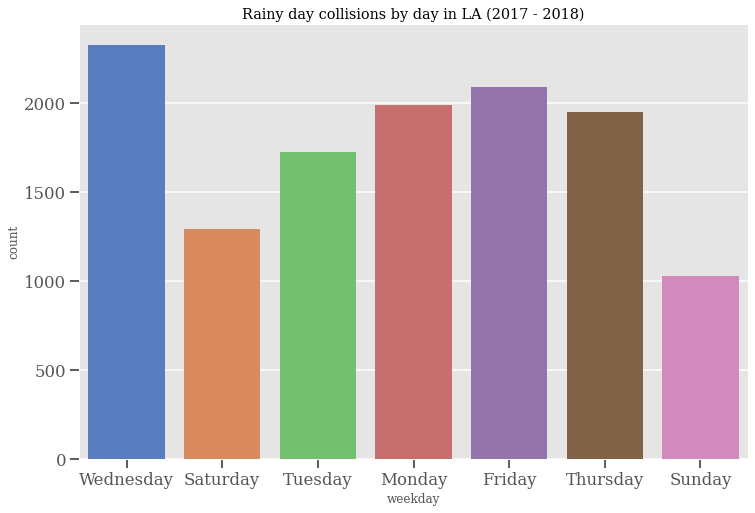

In [31]:
# collisions by rainy weekday
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'weekday',data = rainydays,palette='muted')
#ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], fontsize=10)
ax.set_title('Rainy day collisions by day in LA (2017 - 2018)');

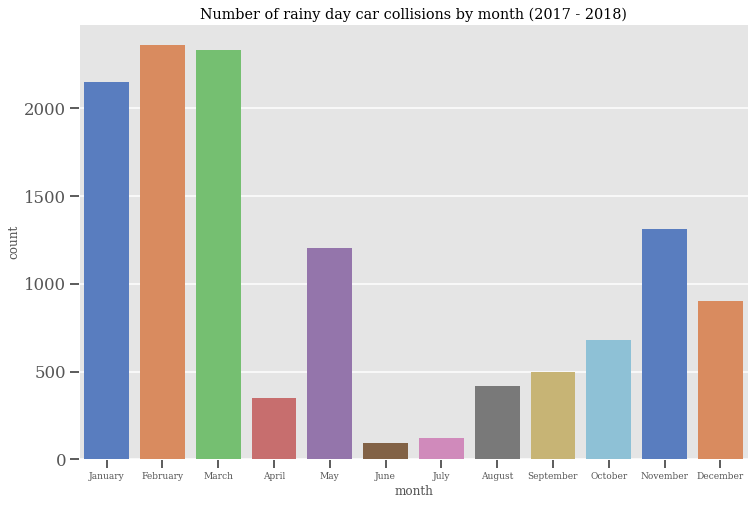

In [32]:
# collisions by rainy months
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = rainydays,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of rainy day car collisions by month (2017 - 2018)');

In [33]:
rainydays['AverageTemp'].mean()

59.94631629856521

# Analysis: Time/Date

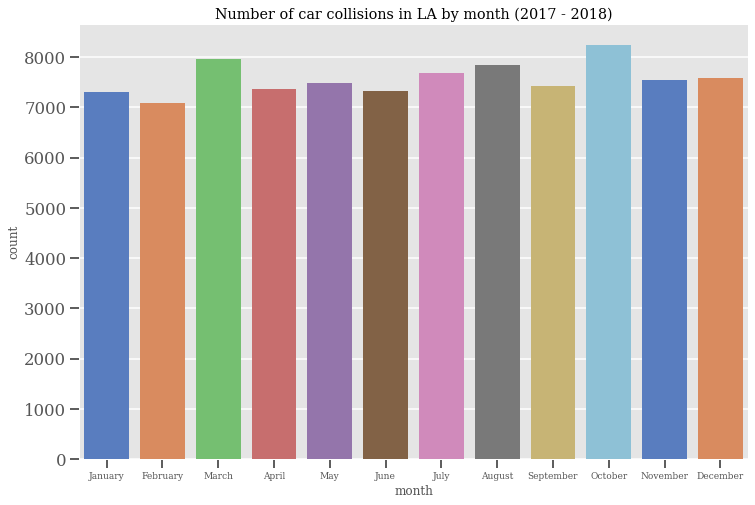

In [34]:
# Time, Collisions by month
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2017 - 2018)');

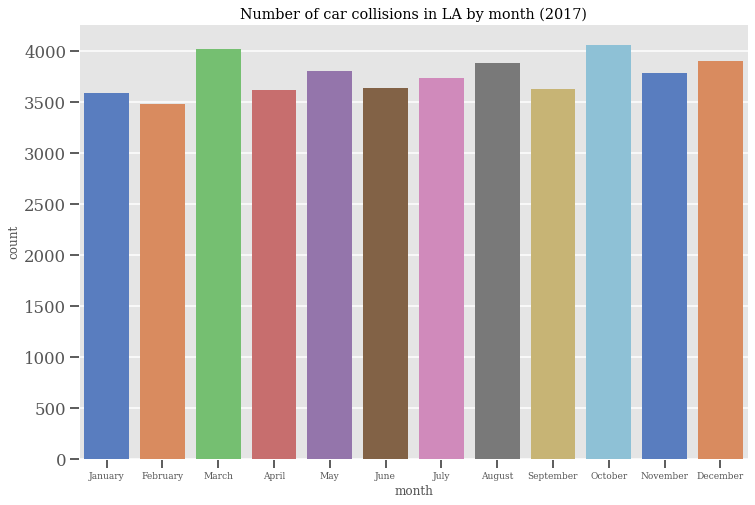

In [35]:
# Collisions by month in 2017 

fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la_2017,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2017)');



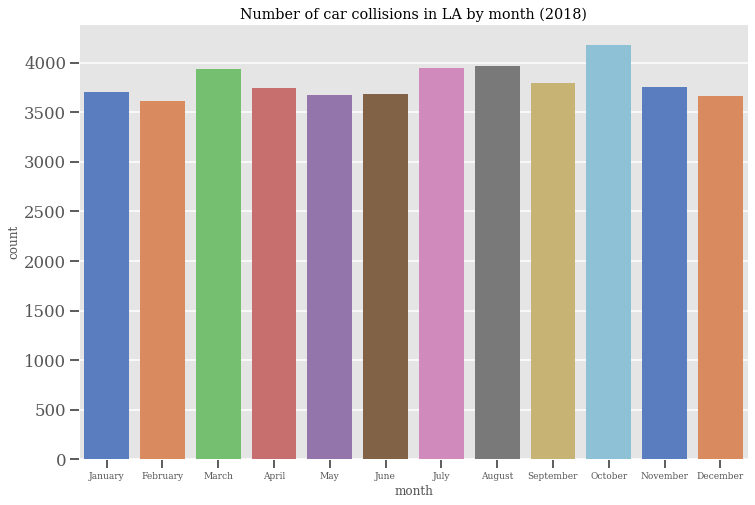

In [36]:
# Collisions by month in 2018

fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la_2018,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2018)');

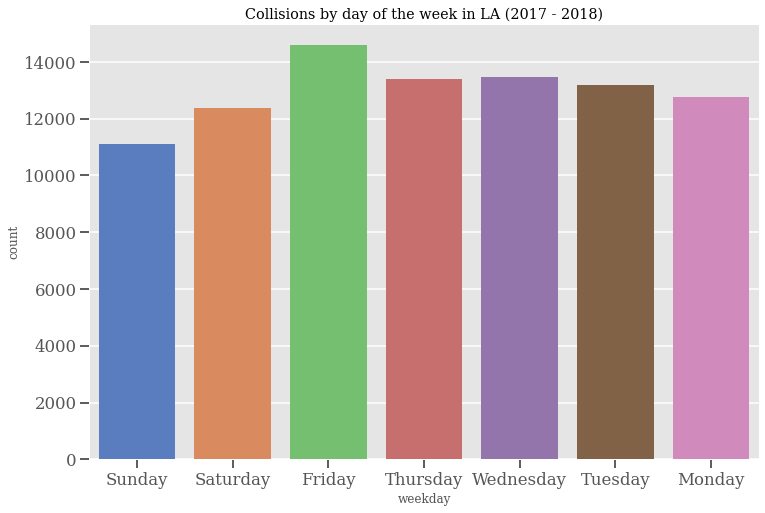

In [37]:
# collisions by weekday
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'weekday',data = la,palette='muted')
#ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], fontsize=10)
ax.set_title('Collisions by day of the week in LA (2017 - 2018)');

# Analysis: Location

In [38]:
## Visualize the data with MapBox
# Source of Map Code: https://towardsdatascience.com/famished-on-the-freeway-visualizing-mapping-la-restaurant-inspections-cb6bc8338111

# in case html doesn't output locally, check out the html file sample in the included zip

mapbox_token="pk.eyJ1IjoianRmaWVsZHMiLCJhIjoiY2p5dWxxcXJxMDF3ZjNtcm9iYmkyZ2w2ZSJ9.353KtPjbC39lk9uVt3r8PQ"
#data parameters from the file to map
trace = go.Scattermapbox(lat = laWeather["latitude"], lon = laWeather["longitude"], marker=go.Marker(size=10), mode="markers+text")
data = [trace]
#define map layout - access token (API), which location map should be centered on
layout = go.Layout(mapbox=dict(accesstoken=mapbox_token,center=dict(lat=33.9703, lon=-118.2775), zoom=10))
#finalize data and layout
figure = go.Figure(data = data, layout = layout)
#draw the map NOTE: map will open in your default browser - new tab
offline.plot(figure)

#33.9703° N, 118.2775° W - 77th st POLICE STATION

/Users/prasadkulkarni/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




'temp-plot.html'

In [39]:
##Create a different MapBox view of the same data
shaz13_custom_style = "mapbox://styles/shaz13/cjiog1iqa1vkd2soeu5eocy4i"
#set the geo=spatial data
data = [go.Scattermapbox(lat = laWeather["latitude"], lon = laWeather["longitude"],mode='markers',
    marker=dict(size= 4,color = 'gold',opacity = .8,),)]
#set the layout to plot
layout = go.Layout(autosize=False,mapbox= dict(accesstoken=mapbox_token,
    bearing=10,pitch=60,zoom=13,center= dict(lat=34.03,lon=-118.46),
    style=shaz13_custom_style),width=900,height=600,title = "LA Traffic Collisions 2017-2018")
fig = dict(data=data, layout=layout)
offline.plot(fig)

'temp-plot.html'

In [40]:
##Create a Map Box plot which also includes weather data
#Hot Days
hot = laWeather[laWeather['HighTemp'] > 100]
#Cool Days
cool = laWeather[laWeather['LowTemp'] < 40]
data = [go.Scattermapbox(
            lat= hot['latitude'] ,
            lon= hot['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'gold',
                opacity = .8),
            name ='Hot'
          ),
        go.Scattermapbox(
            lat= cool['latitude'] ,
            lon= cool['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'cyan',
                opacity = .8),
            name ='Cool'
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken=mapbox_token,
                                bearing=10,
                                pitch=60,
                                zoom=11,
                                center= dict(
                                         lat=34.0482,
                                         lon=-118.4),
                                style= "mapbox://styles/shaz13/cjiog1iqa1vkd2soeu5eocy4i"),
                    width=900,
                    height=600, title = "LA Accidents 2017-2018 on Hot and Cool Days")
fig = dict(data=data, layout=layout)
#offline.plot(fig)
plotly.offline.plot(fig, filename='traffic-weather-temp.html')

'traffic-weather-temp.html'

In [41]:
##Create a Map Box plot which also includes weather data
#Sunrise
rain = laWeather[laWeather['Precipitation'] > 0.01]
#Not Rain
notRain = laWeather[laWeather['Precipitation']==0]
data = [go.Scattermapbox(
            lat= rain['latitude'] ,
            lon= rain['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'gold',
                opacity = .8),
            name ='rain'
          ),
        go.Scattermapbox(
            lat= notRain['latitude'] ,
            lon= notRain['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'cyan',
                opacity = .8),
            name ='no rain'
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken=mapbox_token,
                                bearing=10,
                                pitch=60,
                                zoom=11,
                                center= dict(
                                         lat=34.0482,
                                         lon=-118.4),
                                style= "mapbox://styles/shaz13/cjiog1iqa1vkd2soeu5eocy4i"),
                    width=900,
                    height=600, title = "LA Accidents 2017-2019 with/without precipitation")
fig = dict(data=data, layout=layout)
#offline.plot(fig)
plotly.offline.plot(fig, filename='traffic-weather.html')

'traffic-weather.html'

77th Street    6318
Wilshire       5465
Southwest      5439
Olympic        5046
Newton         4969
Van Nuys       4690
N Hollywood    4652
Pacific        4530
Devonshire     4519
West Valley    4478
West LA        4384
Hollywood      4271
Mission        4129
Topanga        4120
Central        4062
Southeast      3655
Northeast      3580
Hollenbeck     3252
Rampart        3247
Foothill       3187
Harbor         2852
Name: Area Name, dtype: int64

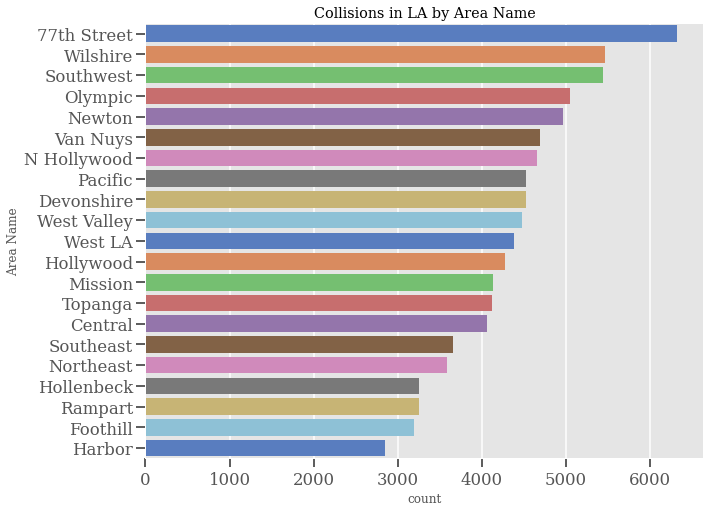

In [42]:
# collisions by area name, descending values, ORDERED

fig,ax = plt.subplots(figsize=(10,8))
descending_order = la['Area Name'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la,y="Area Name",order=descending_order, palette='muted')
ax.set_title('Collisions in LA by Area Name');

la['Area Name'].value_counts()

In [43]:
# use the Premise Description field to look at different locations of collisions, we can see that parking lot is the second most common type of collisions after street

la['Premise Description'].value_counts()

STREET                                                      86807
PARKING LOT                                                  3145
SIDEWALK                                                      328
ALLEY                                                         156
DRIVEWAY                                                      128
FREEWAY                                                        79
GAS STATION                                                    35
SINGLE FAMILY DWELLING                                         29
TRANSPORTATION FACILITY (AIRPORT)                              20
OTHER/OUTSIDE                                                  13
GARAGE/CARPORT                                                 12
PARK/PLAYGROUND                                                12
PARKING UNDERGROUND/BUILDING                                   11
OTHER PREMISE                                                  11
PEDESTRIAN OVERCROSSING                                         8
RESTAURANT

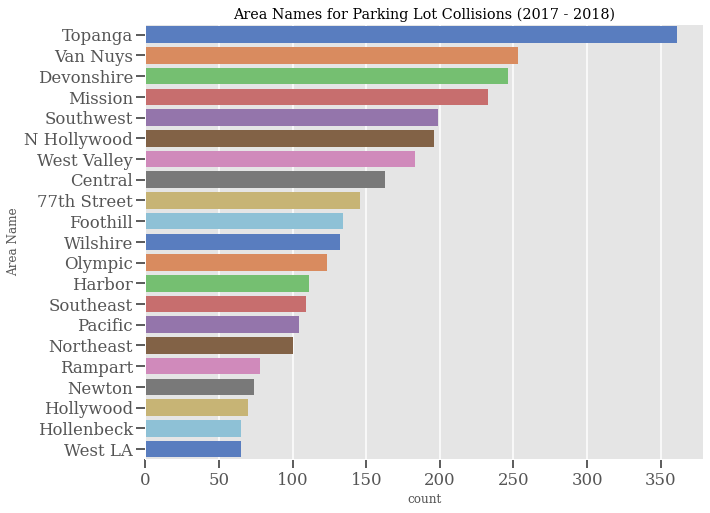

In [44]:
# Explore the area names of parking lot collisions to see if there is any commonality with the normal street collision areas

#look at parking lot only
la_parkinglot = la[la['Premise Description'] == 'PARKING LOT']

fig,ax = plt.subplots(figsize=(10,8))
descending_order = la_parkinglot['Area Name'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la_parkinglot,y="Area Name",order=descending_order, palette='muted')
ax.set_title('Area Names for Parking Lot Collisions (2017 - 2018)');

#la['Area Name'].value_counts()

14    7836
12    7718
13    7698
9     7496
7     6642
3     6287
8     6126
6     5830
4     5730
10    5628
5     5563
2     5310
11    4748
15    4338
1     3895
Name: Council Districts, dtype: int64

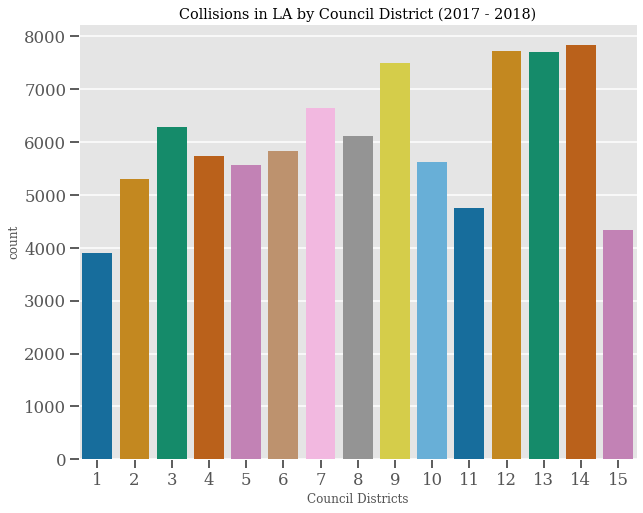

In [45]:
# Look at collisions by Council District 

fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Council Districts",data=la,palette='colorblind')
ax.set_title('Collisions in LA by Council District (2017 - 2018)');

la['Council Districts'].value_counts()

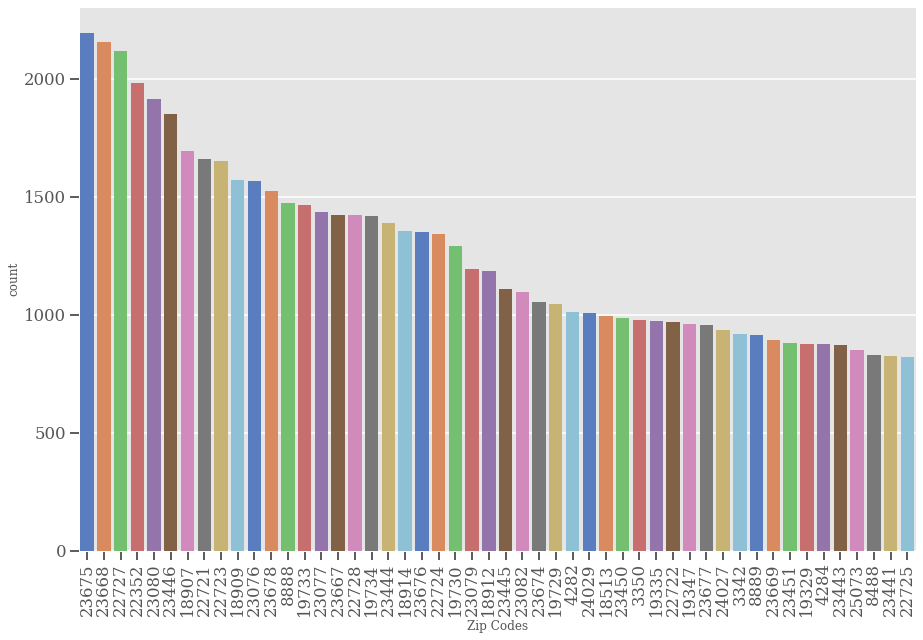

In [46]:
# Collisions by zip code

# TO DO, make top 50, descending order, add title, vertical X axis
descending_order = la['Zip Codes'].value_counts().sort_values(ascending=False).index[:50]
#sns.countplot(data=la,x="Zip Codes",order=descending_order, palette = 'muted')

#sort_values(ascending=0)[:10].plot(kind='bar')

fig,ax = plt.subplots(figsize=(15,10)), plt.xticks(rotation=90)
sns.countplot(x="Zip Codes",data=la, palette='muted', order=descending_order)
#ax.set_title('Collissions in LA by Zip Code (2017 - 2018)');

#la['Zip Codes'].value_counts()

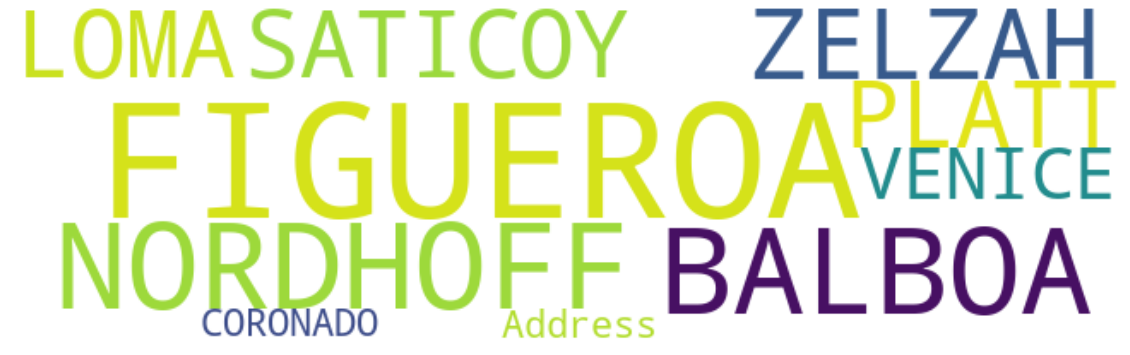

In [47]:
# Here we examine the Address streets involved in collisions

# note, the word cloud changes every time run so may not match word doc exactly

# address streets word cloud (uses 'car outline.png' for image mask)

STOPWORDS = 'dtype', 'Area', '2ND', '1ST', 'Object', '8th', 'TR', 'MAIN', 'Name', '7th', '6th', 'PL','Length', 'AV', 'ST', 'DR', 'AVENUE', 'RD', 'VIEW', 'FY', 'WY', 'BL', 'Cross', 'Street'
text = la['Address'] 
text = str(text)

#car outline.png
car_mask = np.array(Image.open(requests.get('https://www.dropbox.com/s/epiqafjhtzusok8/caroutline.png?dl=1', stream=True).raw))
#car_mask = np.array(Image.open("caroutline.png"))
#car_mask

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
transformed_car_mask = np.ndarray((car_mask.shape[0], car_mask.shape[1]), np.int32)

wc1 = WordCloud(collocations=False, stopwords=STOPWORDS, background_color="white", max_words=1000, mask=transformed_car_mask, contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc1.generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.show()

#export the file
#wc.to_file("carfinal.png")

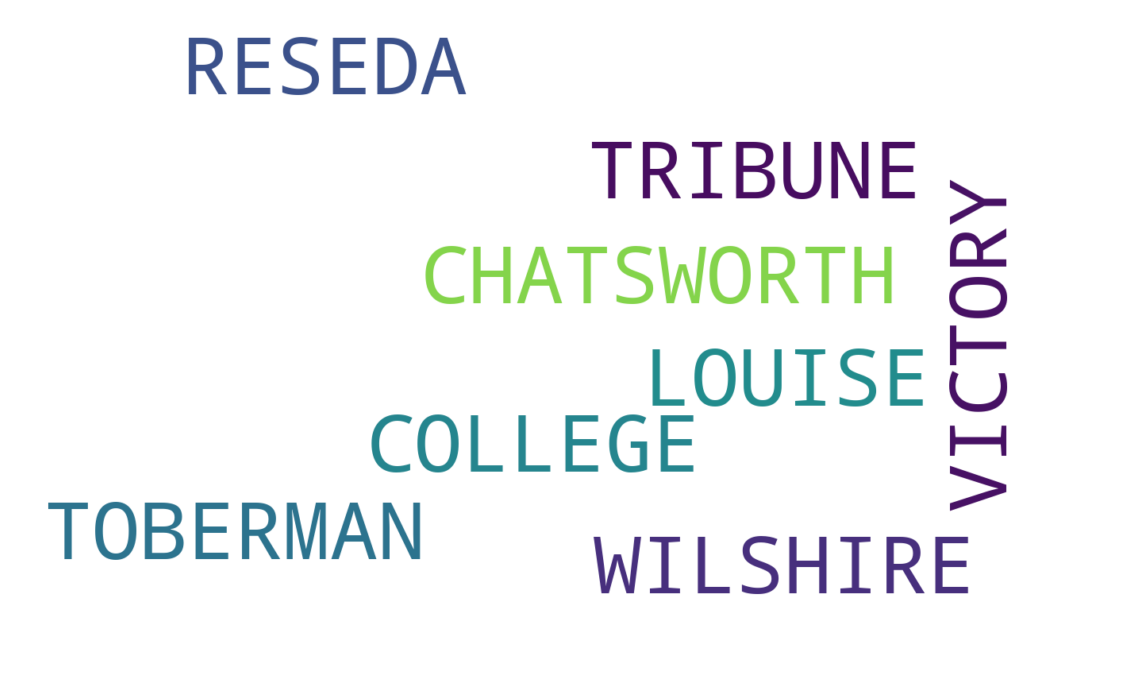

In [48]:
# Here we examine the cross streets involved in collisions

# note, the word cloud changes every time run so may not match word doc exactly

# cross streets wordcloud (uses image 'whitecar.png' for image mask)

STOPWORDS = 'dtype', 'Area', '2ND', '1ST', 'Object', '8th', 'MAIN', 'Name', '7th', '6th', 'PL','Length', 'AV', 'ST', 'DR', 'AVENUE', 'RD', 'VIEW', 'FY', 'WY', 'BL', 'Cross', 'Street'
text = str(la['Cross Street'])

# mask = np.array(Image.open("whitecar.png"))
mask = np.array(Image.open(requests.get('https://www.dropbox.com/s/yag9o4komljn5yx/whitecar.png?dl=1', stream=True).raw))
transformed_car_mask1 = np.ndarray((mask.shape[0], mask.shape[1]), np.int32)
wc2 = WordCloud(collocations=False,stopwords= STOPWORDS, background_color="white", max_words=1000,mask=transformed_car_mask1, 
               max_font_size=100, random_state=10)
wc2.generate(text)

# create coloring from image mask
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wc2, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
_=plt.show()

# Analysis: Demographics

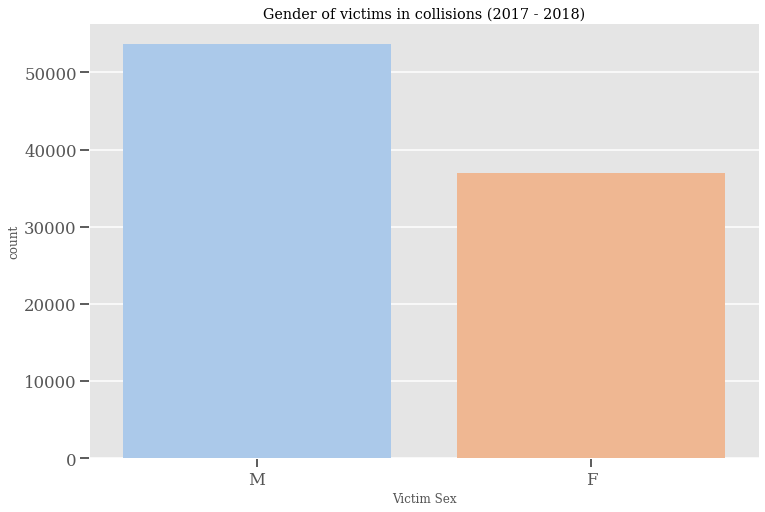

In [49]:
# Collision by gender

fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(data=la,x="Victim Sex",palette='pastel', order=la['Victim Sex'].value_counts().iloc[:2].index)
ax.set_title('Gender of victims in collisions (2017 - 2018)');

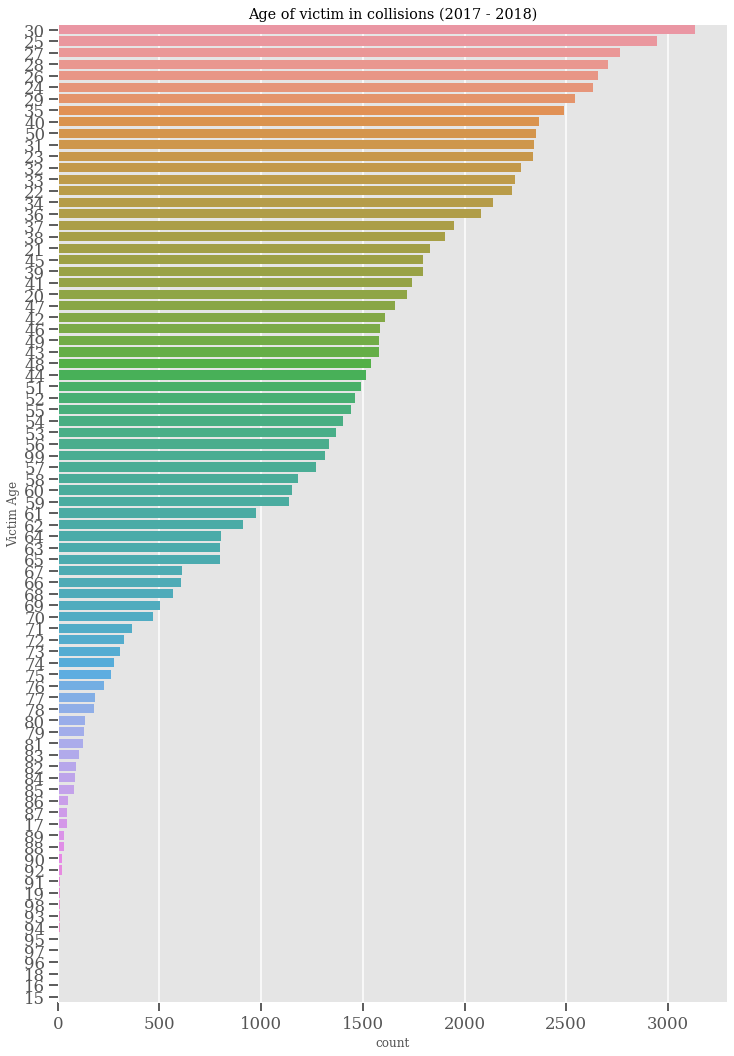

In [50]:
# Age sorted by collision 


fig,ax = plt.subplots(figsize=(12,18))
descending_order = la['Victim Age'].value_counts().sort_values(ascending=False).index
#ascending_order = la['Victim Age'].sort_values(ascending=True).index
sns.countplot(data=la,y="Victim Age",order=descending_order)
ax.set_title('Age of victim in collisions (2017 - 2018)');

Text(0, 0.5, 'Density')

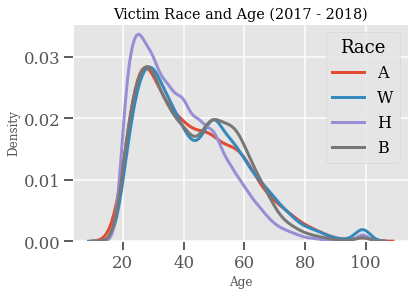

In [51]:
# Victim race by age breakdown

# List of races to plot
races = ['A', 'W', 'H', 'B' ]

# Iterate through 
for race in races:
    subset = la[la['Victim Descent'] == race]
    
    # Draw the density plot
    sns.distplot(subset['Victim Age'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = race)
    

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Race and Age (2017 - 2018)')
plt.xlabel('Age')
plt.ylabel('Density')

In [52]:
# breakdown of victim races (2017 - 2018)
la['Victim Descent'].value_counts()

H    37657
W    20484
B    13529
O    12256
A     3730
X     1820
K      717
F      285
C      126
U       48
J       42
V       35
Z       35
P       30
I       29
G       12
S        5
D        4
L        1
Name: Victim Descent, dtype: int64

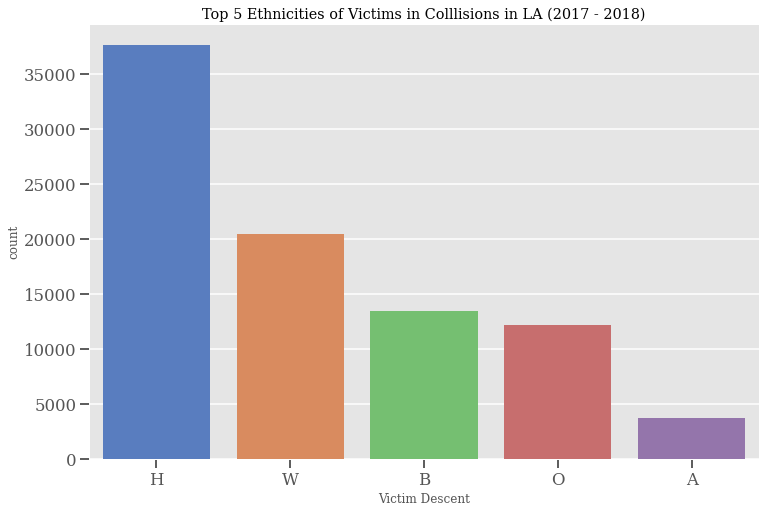

In [53]:
# Victims
# variables with very little count were ommitted, top 5 displayed
fig,ax = plt.subplots(figsize=(12,8))

descending_order = la['Victim Descent'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la,x="Victim Descent", palette = 'muted',  order=la['Victim Descent'].value_counts().iloc[:5].index)
ax.set_title('Top 5 Ethnicities of Victims in Colllisions in LA (2017 - 2018)');

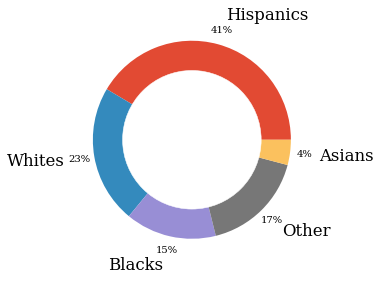

In [54]:
# victim descent donut chart  

# library
import matplotlib.pyplot as plt
 
# Data
names='Hispanics', 'Whites', 'Blacks', 'Other', 'Asians',
size=[41.47, 22.56, 14.86, 17, 4.11]
 
# create a figure and set different background
fig = plt.figure()
fig.patch.set_facecolor('white')
 
# Change color of text
plt.rcParams['text.color'] = 'black'
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
 
# Pieplot + circle on it
plt.pie(size, labels=names, autopct='%1.0f%%', pctdistance=1.15, labeldistance=1.3)
p=plt.gcf()
p.gca().add_artist(my_circle) 
plt.tight_layout()
#plt.title('Victim Ethnicities (2017 - 2018)', y=-0.01)

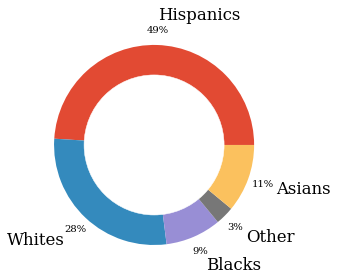

In [55]:
# victim descent donut chart for LA population in general, percentages are in the size variable 

# library
import matplotlib.pyplot as plt
 
# Data
names='Hispanics', 'Whites', 'Blacks', 'Other', 'Asians',
size=[49, 28, 9, 3, 11]
 
# create a figure and set different background
fig = plt.figure()
fig.patch.set_facecolor('white')
 
# Change color of text
plt.rcParams['text.color'] = 'black'
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
 
# Pieplot + circle on it
plt.pie(size, labels=names, autopct='%1.0f%%', pctdistance=1.15, labeldistance=1.3)
p=plt.gcf()
p.gca().add_artist(my_circle) 
plt.tight_layout()
#plt.title('Victim Ethnicities (2017 - 2018)', y=-0.01)

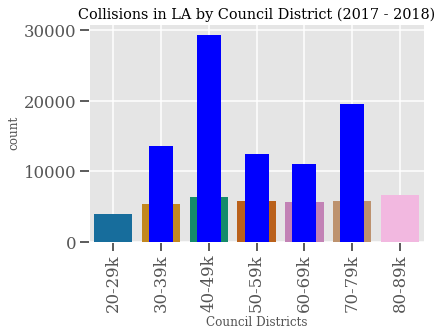

In [56]:
# make bins of Median Income

import matplotlib
plt.style.use('ggplot')
#df_ages['age_bins'] = pd.cut(x=df_ages['age'], bins=[20, 29, 39, 49])
la['income_bins'] = pd.cut(x=la['Median Income'], bins=[20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000], labels=['20-29k', '30-39k', '40-49k', '50-59k', '60-69k', '70-79k', '80-89k'])
#la['Median Income'].round(0)
#la['Median Income'].astype(int)

#la.income_bins.head()



#width = 0.35       
#a = la.groupby('income_bins').size()
#plt.bar(la, a, width, label='Normal')

fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Council Districts",data=la,palette='colorblind')
ax.set_title('Collisions in LA by Council District (2017 - 2018)')

ax = la['income_bins'].value_counts(sort=False).plot.bar(rot=0, color='b', figsize=(6,4)), plt.xticks(rotation=90)
#ax.set_xticklabels([c[1:-1].replace(","," to") for c in la['income_bins'].cat.categories])
plt.show()
#ax.set_title('Median Income Binned (2017 - 2018)')
#sns.countplot(data=la,x="Median Income", palette = 'muted',  order=la['Median Income'].value_counts().iloc[:5].index)

Text(0.5, 1.0, 'Income Distribution of Colission Victims (2017 - 2018)')

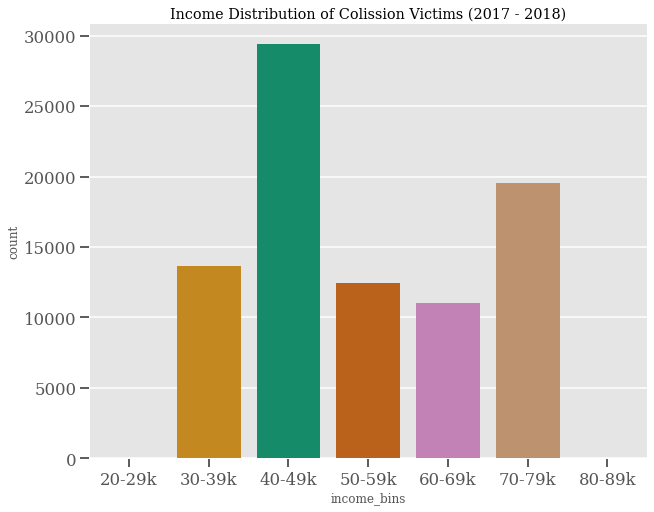

In [57]:
# Income Distribution of colission victims

fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x="income_bins",data=la,palette='colorblind')
ax.set_title('Income Distribution of Colission Victims (2017 - 2018)')

# Analysis: Time & Location

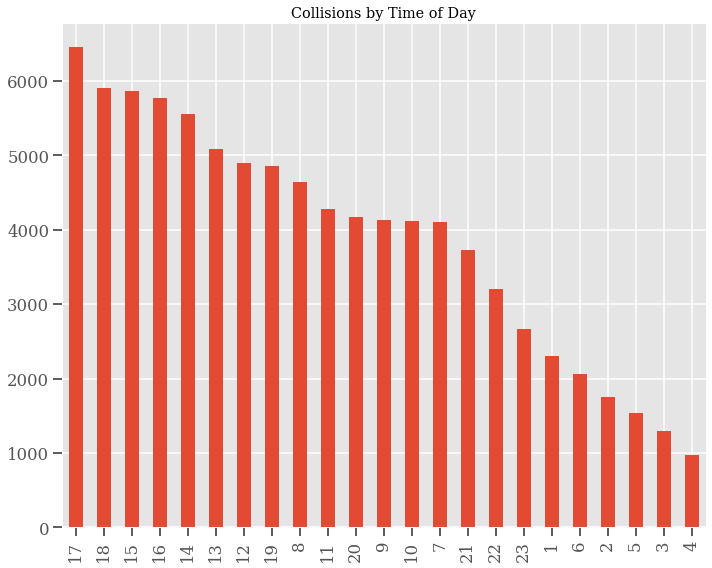

In [58]:
# Time and Location Analysis Maps printed to directory

la1 = la.merge(weather, how='inner', on=['Date'], sort=True)


la1.drop(["Unnamed: 0"], axis= 1, inplace=True) #space in unnamed
la1.drop(['Location'], axis=1 , inplace=True)
la1 = la1.rename(columns = lambda col: col.replace(" ", ""))
#la1 = la.copy()
la1.head()

la1['NauticalTwilightRise'] = pd.to_datetime(la1['NauticalTwilightRise'], format='%H:%M').dt.hour#

# put NauticalTwilightSet into integer add 12 to it then put into date time

#add PM to NauticalTwilightSet

la1['NauticalTwilightSet'] = la1['NauticalTwilightSet'] + " PM"


la1['NauticalTwilightSet'] = pd.to_datetime(la1['NauticalTwilightSet'], format='%H:%M %p').dt.hour#


la1['NauticalTwilightSet'] = la1['NauticalTwilightSet'] + 12
#adding PM to each row


fig,ax = plt.subplots(figsize=(10,8))
la1['TimeOccurred'].value_counts().plot(kind='bar')
plt.title("Collisions by Time of Day")
plt.tight_layout()

Summary of top VictimSex occurences 

M    35342
F    26517
X      154
H       11
N        2
Name: VictimSex, dtype: int64


Text(0.5, 1.0, 'VictimSex counts during day light')

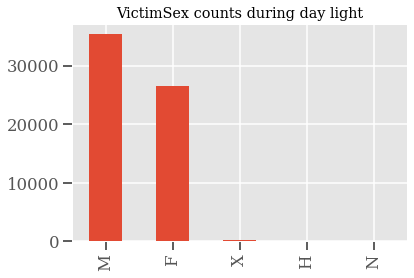

In [59]:
def vc_fun(df, column_name, *args):
    '''

    :param df: dataframe
    :param column_name: A STRING - a column to value_counts
    :param args: if args then add .nlargest()  enter a number for how many largest
    :return: print value counts summary
    '''
    if args:
        print("Summary of top " + column_name + " occurences \n")
        print(df[column_name].value_counts().nlargest(args[0]))
    else:
        print("Summary of top " + column_name + " occurences \n")
        print(df[column_name].value_counts())



sunny_days = (la1['TimeOccurred'] > la1['NauticalTwilightRise']) & (la1['TimeOccurred'] < la1['NauticalTwilightSet'])

sunny_df = la1.loc[sunny_days == True]

vc_fun(sunny_df, 'VictimSex')

sunny_df['VictimSex'].value_counts().plot(kind='bar')
plt.title("VictimSex counts during day light")

In [60]:
night_df = la1.loc[sunny_days == False]

vc_fun(night_df, 'VictimSex')

Summary of top VictimSex occurences 

M    17446
F     9824
X       75
H        6
N        4
Name: VictimSex, dtype: int64


Proportion of each VictimDescent in collisions during day
A    0.703512
B    0.688655
C    0.772358
D    0.750000
F    0.727599
G    0.583333
H    0.684384
I    0.793103
J    0.666667
K    0.734752
L    1.000000
O    0.676093
P    0.814815
S    0.500000
U    0.833333
V    0.588235
W    0.725231
X    0.648739
Z    0.714286
Name: VictimDescent, dtype: float64


Text(0.5, 1.0, 'Proportion of VictimDescent in DayTime Collisions')

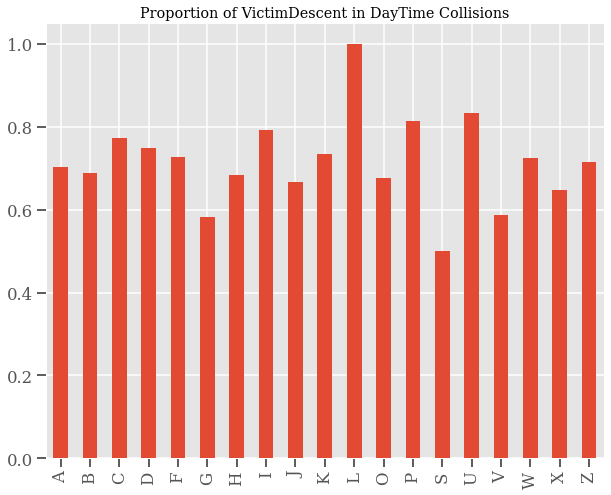

In [61]:
#proportion of each VictimDescent in collisions during day / night

print("Proportion of each VictimDescent in collisions during day")

print(sunny_df['VictimDescent'].value_counts()/la1['VictimDescent'].value_counts())

fig,ax = plt.subplots(figsize=(10,8))
(sunny_df['VictimDescent'].value_counts()/la1['VictimDescent'].value_counts()).plot(kind='bar')

plt.title("Proportion of VictimDescent in DayTime Collisions")

Proportion of each VictimDescent in collisions during day
A    0.296488
B    0.311345
C    0.227642
D    0.250000
F    0.272401
G    0.416667
H    0.315616
I    0.206897
J    0.333333
K    0.265248
L         NaN
O    0.323907
P    0.185185
S    0.500000
U    0.166667
V    0.411765
W    0.274769
X    0.351261
Z    0.285714
Name: VictimDescent, dtype: float64


Text(0.5, 1.0, 'Proportion of VictimDescent in NightTime Collisions')

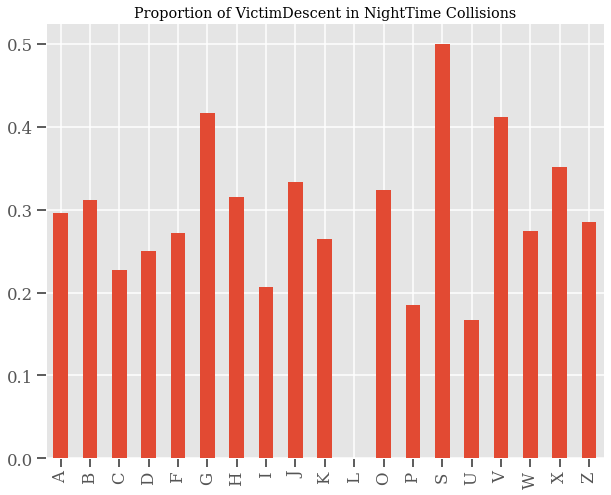

In [62]:
print("Proportion of each VictimDescent in collisions during day")
print(night_df['VictimDescent'].value_counts()/la1['VictimDescent'].value_counts())

fig,ax = plt.subplots(figsize=(10,8))
(night_df['VictimDescent'].value_counts()/la1['VictimDescent'].value_counts()).plot(kind='bar')
plt.title("Proportion of VictimDescent in NightTime Collisions")

CrossStreets with the most collision 

VERMONT                      AV    740
FIGUEROA                     ST    674
WESTERN                      AV    634
SHERMAN                      WY    612
VICTORY                      BL    587
SEPULVEDA                    BL    577
BROADWAY                           561
VANOWEN                      ST    558
ROSCOE                       BL    515
PICO                         BL    512
3RD                          ST    502
Name: Cross Street, dtype: int64


Text(0.5, 1.0, 'CrossStreets with the highest collision totals')

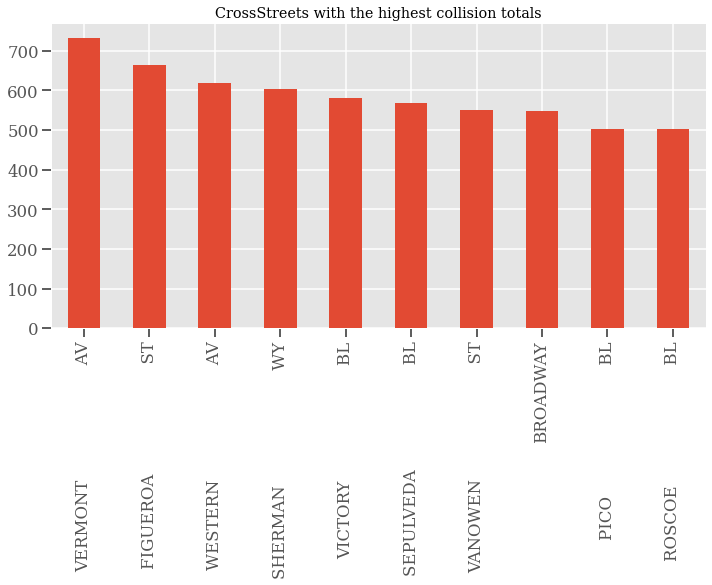

In [63]:
print("CrossStreets with the most collision \n")
print(la['Cross Street'].value_counts()[la['Cross Street'].value_counts() > 500])
fig,ax = plt.subplots(figsize=(10,8))
la1['CrossStreet'].value_counts()[la1['CrossStreet'].value_counts() > 500].plot(kind='bar')
#plt.xticks(rotation = 45)
plt.tight_layout()
plt.title("CrossStreets with the highest collision totals")

Addresses with the most collisions 

WESTERN                      AV    1322
SHERMAN                      WY    1242
VENTURA                      BL    1239
VICTORY                      BL    1129
SEPULVEDA                    BL    1120
VERMONT                      AV    1083
FIGUEROA                     ST    1053
ROSCOE                       BL     938
VANOWEN                      ST     900
OLYMPIC                      BL     888
VAN NUYS                     BL     876
SUNSET                       BL     834
PICO                         BL     788
BROADWAY                            729
NORMANDIE                    AV     701
WILSHIRE                     BL     696
VENICE                       BL     661
LAUREL CANYON                BL     634
CENTRAL                      AV     622
WASHINGTON                   BL     613
FLORENCE                     AV     594
3RD                          ST     576
LA BREA                      AV     572
TOPANGA CANYON               BL     557
CRE

Text(0.5, 1.0, 'Address with the highest collision totals')

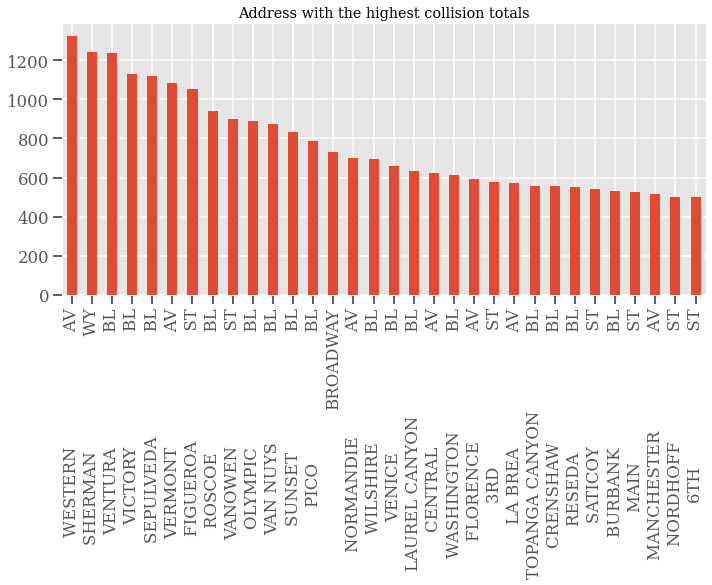

In [64]:
print("Addresses with the most collisions \n")
print(la['Address'].value_counts()[la['Address'].value_counts() >500])

fig,ax = plt.subplots(figsize=(10,8))
la['Address'].value_counts()[la['Address'].value_counts() > 500].plot(kind='bar')
#plt.xticks(rotation = 45)
plt.tight_layout()
plt.title("Address with the highest collision totals")

In [65]:
def get_coords(df):
    '''

    :param df: dataframe with coordinates listed as latitude and longitude
    :return: list of tuples lat and lon
    '''
    coords = list(zip(df.latitude, df.longitude))
    return coords

def map_LAcoords(tuple_list, size, desired_file_name, type):
    '''

    :param tuple_list: a list of tuples
    :param size: for heat map. always specify number
    :param desired_file_name: file name you want
    :param type: 'heat' or 'Heat' will make a heat map. specify something else for points
    :return: plots a map of LA with given coordinates in heatmap
    '''
    the_map = folium.Map(location=(34.052235,-118.243683))
    if type == 'heat' or type == 'Heat':
        HeatMap(tuple_list, radius=size).add_to(the_map)
        the_map.save(desired_file_name + "map.html")
    else:
        for coord in tuple_list:
            folium.Marker(coord).add_to(the_map)
        the_map.save(desired_file_name + "map.html")

In [66]:
coordSunny = get_coords(sunny_df)

#make the map save it
map_LAcoords(coordSunny, 13, 'SunnyCrash', 'heat')
print("Sunny Crash Map created successfully \n")

#make mape and save it
coordNight = get_coords(night_df)

map_LAcoords(coordNight, 13, 'NightCrash', 'heat')
print("Night Crash Map created successfully \n")

#Analyze day of the week by time.

#which days had the most crashes

In [67]:
vc_fun(la1, 'Date', 10)
vc_fun(la1, 'month', 5) #which months had the most crashes
vc_fun(la1, 'weekday') #which weekday had the most crashes
vc_fun(la1, 'AverageTemp', 10) #top 10 most occurring temperatures in collisions
vc_fun(la1, 'HighTemp', 10)
vc_fun(la1, 'LowTemp', 10) # summary of top Low temp occurences
vc_fun(la1, 'Precipitation', 10)

Summary of top Date occurences 

2018-10-12    179
2017-12-01    173
2018-09-21    171
2018-01-08    170
2017-08-25    170
2018-01-09    169
2017-11-04    168
2017-11-30    166
2018-12-07    165
2017-11-17    165
Name: Date, dtype: int64
Summary of top month occurences 

10    8238
3     7854
8     7852
7     7688
11    7551
Name: month, dtype: int64
Summary of top weekday occurences 

Friday       14313
Wednesday    13456
Thursday     13270
Tuesday      12931
Monday       12522
Saturday     12022
Sunday       10867
Name: weekday, dtype: int64
Summary of top AverageTemp occurences 

63    4603
73    4345
67    4285
64    4008
60    3932
65    3881
72    3858
68    3638
61    3568
74    3213
Name: AverageTemp, dtype: int64
Summary of top HighTemp occurences 

75    3616
79    3615
77    3565
74    3369
88    3134
83    3099
86    2961
71    2836
72    2654
70    2640
Name: HighTemp, dtype: int64
Summary of top LowTemp occurences 

57    4889
54    4873
53    4766
60    4650
56    3789
6

In [68]:
print("Top 8 CrossStreets and Address by collision counts \n")

print(la1.groupby(['CrossStreet', 'Address']).size().nlargest(8))

cros_and_add = la1.groupby(['CrossStreet', 'Address']).size() > 45
print("The Streets with the most accidents \n")
print(la1.groupby(['CrossStreet', "Address"]).size().nlargest(8))

cross_add = la1.groupby(['CrossStreet', "Address"]).size() >= 46
la2 = la1.copy()

la2.set_index(['CrossStreet', 'Address'], inplace=True)

cross_add = la2.loc[cross_add]

cross_add_coords = get_coords(cross_add)

len(cross_add_coords) # 413 points.

Top 8 CrossStreets and Address by collision counts 

CrossStreet                      Address                        
SEPULVEDA                    BL  SHERMAN                      WY    60
NORDHOFF                     ST  TAMPA                        AV    59
WOODMAN                      AV  SHERMAN                      WY    53
WHITSETT                     AV  SHERMAN                      WY    52
RODEO                        RD  LA BREA                      AV    50
SEPULVEDA                    BL  BURBANK                      BL    47
VICTORY                      BL  TOPANGA CANYON               BL    47
PLUMMER                      ST  TAMPA                        AV    45
dtype: int64
The Streets with the most accidents 

CrossStreet                      Address                        
SEPULVEDA                    BL  SHERMAN                      WY    60
NORDHOFF                     ST  TAMPA                        AV    59
WOODMAN                      AV  SHERMAN                

368

In [70]:
map_LAcoords(cross_add_coords,13, 'CrossStreets&Address', 'point')
print("CrossStreets & Address Map created successfully \n")

CrossStreets & Address Map created successfully 



Text(0.5, 1.0, 'Time Series Crashes over two year period')

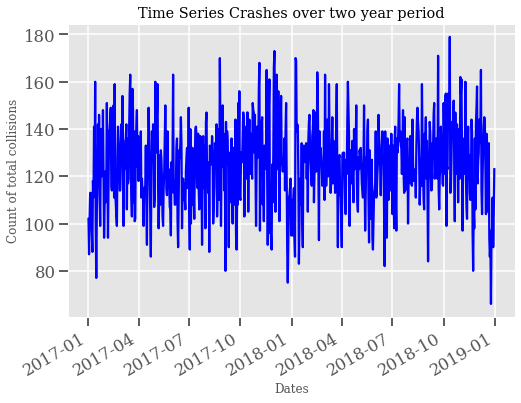

In [71]:
#time series

fig,ax = plt.subplots(figsize=(8,6))

time_series1 = la1['Date'].value_counts()

ax = time_series1.plot(color="blue")
#plt.show() = shows plot
ax.set_ylabel("Count of total collisions")
ax.set_xlabel("Dates")
ax.set_title('Time Series Crashes over two year period')

Text(0.5, 1.0, 'View of weekly patterns over a few months')

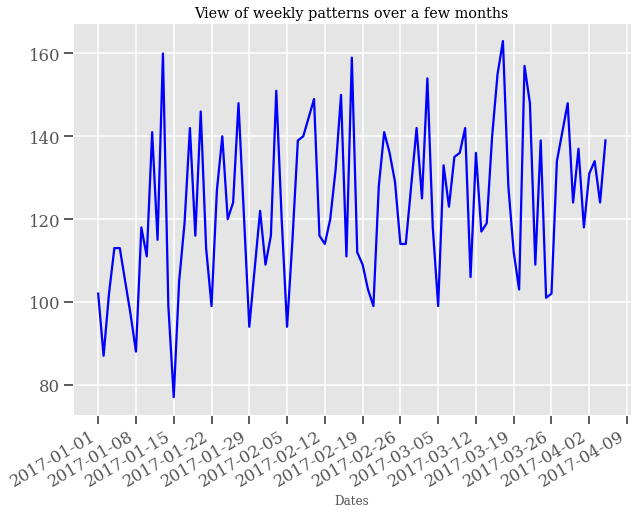

In [72]:
la2 = la1.copy()

la2.reset_index(inplace = True)

series_dates = la2['Date'].value_counts()

la2.set_index('Date', inplace = True)

time_series1 = la2['2017-01-01':'2017-04-05']

la2.reset_index(inplace= True)

time_series1.reset_index(inplace= True)


counts1 = time_series1['Date'].value_counts()


fig,ax = plt.subplots(figsize=(10,8))

ax = counts1.plot(color='blue')

tick_spacing = 7 # for each week

ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_xlabel("Dates")
ax.set_title("View of weekly patterns over a few months")

# Twitter Analysis: Unstructured Data

In [117]:
# ***********************************************************************************
#       Twitter feeds keywords collection
# ***********************************************************************************

def get_tweets(startdate, enddate, maxtweet):
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch('latraffic')\
                                                .setSince(startdate)\
                                                .setUntil(enddate)\
                                                .setMaxTweets(maxtweet)
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    text_tweets = [[tw.username,
                tw.text,
                tw.date,
                tw.retweets,
                tw.favorites,
                tw.mentions,
                tw.hashtags,
                tw.geo] for tw in tweet]
    df_tweets= pd.DataFrame(text_tweets, columns = ['User', 'Text', 'Date', 'Favorites', 'Retweets', 'Mentions','Hashtags', 'Geolocation'])
    
    return df_tweets

In [118]:
#intialize Stream
try:
    print('\nStart Streaming...')
    starttime = timeit.default_timer()
    print("The start time is :",starttime)

#     df_la = get_tweets('Losangeles','2010-01-01', '2019-01-01', 100000)
#     df_lacases = get_tweets('2016-01-01', '2017-12-31', 100000)
#     df_lacases = get_tweets('2016-01-01', '2016-12-31', 100000)
    df_lacases = get_tweets('2019-01-01', '2019-12-31', 100000)
#     df_lacases = get_tweets('2017-01-01', '2017-12-31', 100000)

    print("tweets ready")
    print('Total Number of tweets Processed: ',len(df_lacases))
    print("The time difference is :", timeit.default_timer() - starttime)
    df_lacases.head()
    
except KeyboardInterrupt as e :
    print("\nStopped.")

finally:
    print('\nDone.')


Start Streaming...
The start time is : 29703.896171959

Stopped.

Done.


In [ ]:
# ***********************************************************************************
#       Convert to Dictionary for importing into MongoDB
# ***********************************************************************************

# len(df_lacases)

# df_lacases.reset_index(inplace=True)
# data_dict = df_lacases.to_dict("records")
# print('\nDone.')

In [73]:
# ***********************************************************************************
#       Import Twitter feeds into MongoDB collection
# ***********************************************************************************

# Connection to Mongo DB

try:
    client = MongoClient('localhost', 27017)
    print ('Authentication OK - You''re now connected to the MongoDB.\n')
# use database named usgs or create it if not there already
    twdb = client.tweetsmart
    # create collection named tweets or create it if not there already
    tweetscoll = twdb.tweets

#   print('MongoDB: Tweets db with tweets collection has been created')
    print('MongoDB database: ' + str(twdb))
    print('MongoDB collection:' + str(tweetscoll))


# Insert collection
#   tweetscoll.insert_many(data_dict)  # run this only if you turn on earlier section

except pymongo.errors.ConnectionFailure as e:
    print ('Could not connect to MongoDB: %s' % e )

#print the number of docs from db
print('Total Number of Documents: ',tweetscoll.count_documents({}))

Authentication OK - Youre now connected to the MongoDB.

MongoDB database: Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'tweetsmart')
MongoDB collection:Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'tweetsmart'), 'tweets')
Total Number of Documents:  252432


In [74]:
#print the number of docs from db
print('Total Number of Documents: ',tweetscoll.count_documents({}))

#search the first item from the collection
tweetscoll.find_one()

Total Number of Documents:  252432


{'_id': ObjectId('5f4c9a539725376cc77a52c9'),
 'index': 0,
 'User': 'TotalTrafficLA',
 'Text': 'Accident, right lane blocked in #MorenoValley on 60 EB before Heacock St, stopped traffic back to I-215, delay of 24 mins #LAtraffic',
 'Date': datetime.datetime(2018, 12, 31, 23, 39, 56),
 'Favorites': 0,
 'Retweets': 0,
 'Mentions': '',
 'Hashtags': '#MorenoValley #LAtraffic',
 'Geolocation': ''}

In [75]:
# ***********************************************************************************
#       load data from MongoDB collection to python list object
# ***********************************************************************************

starttime = timeit.default_timer()
print("The start time is :",starttime)
tw_list =[]
# results = tweetscoll.find().limit(5) #limit to 5 items
results = tweetscoll.find()

for result in results:
    id = result['_id']
    user = result['User']
    retweets = result['Retweets']
    coords = result['Geolocation']
    mentions = result['Mentions']
    hashtags = result['Hashtags']
    datets = result['Date']
    text = result['Text']
    tw_list.append([id,user,retweets,coords,mentions,hashtags,datets,text])

print('Total Number of Documents Processed: ',len(tw_list))

print("The time difference is :", timeit.default_timer() - starttime)

The start time is : 3286.45104733
Total Number of Documents Processed:  252432
The time difference is : 3.4076300819997414


In [76]:

# ***********************************************************************************
#       load data from python list into Pandas Dataframe
# ***********************************************************************************

#define column names
ColNames = ['id','user','retweets','coords','mentions','hashtags','datets','text']

# Show all columns and do not truncate in the data frame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

tweetsDF = pd.DataFrame(tw_list,columns=ColNames)

print('Total Number of rows Processed: ',len(tweetsDF))



Total Number of rows Processed:  252432


In [77]:
# ***********************************************************************************
#       Dataframe - Cleanup;  Creation of Calender fields
# ***********************************************************************************

# replace NAs
tweetsDF.fillna("",inplace=True)

#Convert to lowercase

tweetsDF['hashtags'] = tweetsDF['hashtags'].str.lower()
tweetsDF['text'] = tweetsDF['text'].str.lower()



#derive other calender items from date.today()
# tweetsDF['datets'].unique()

tweetsDF['date'] = tweetsDF['datets'].dt.date
tweetsDF['year'] = tweetsDF['datets'].dt.year
tweetsDF['month'] = tweetsDF['datets'].dt.month
tweetsDF['monthday'] = tweetsDF['datets'].dt.day
tweetsDF['weekday'] = tweetsDF['datets'].dt.weekday
tweetsDF['dayname'] = tweetsDF['datets'].dt.day_name()
tweetsDF['monthname'] = tweetsDF['datets'].dt.month_name()
tweetsDF['hour'] = tweetsDF['datets'].dt.hour
tweetsDF['minute'] = tweetsDF['datets'].dt.minute
tweetsDF['secs'] = tweetsDF['datets'].dt.second


print('Total Number of rows Processed: ',len(tweetsDF))

tweetsDF.head()


Total Number of rows Processed:  252432


,id,user,retweets,coords,mentions,hashtags,datets,text,date,year,month,monthday,weekday,dayname,monthname,hour,minute,secs
0,5f4c9a539725376cc77a52c9,TotalTrafficLA,0,,,#morenovalley #latraffic,2018-12-31 23:39:56,"accident, right lane blocked in #morenovalley on 60 eb before heacock st, stopped traffic back to i-215, delay of 24 mins #latraffic",2018-12-31,2018,12,31,0,Monday,December,23,39,56
1,5f4c9a539725376cc77a52ca,TotalTrafficLA,0,,,#sanbernardino #latraffic,2018-12-31 23:38:49,"accident, center lane blocked in #sanbernardino on i-215 sb before mill st, stopped traffic back to hwy 66, delay of 9 mins #latraffic",2018-12-31,2018,12,31,0,Monday,December,23,38,49
2,5f4c9a539725376cc77a52cb,TotalTrafficLA,0,,,#valencia #latraffic,2018-12-31 22:37:00,"a crash has the two right lanes blocked. in #valencia on i-5 sb at rye cyn rd, stopped traffic back to hwy 126, delay of 7 mins #latraffic",2018-12-31,2018,12,31,0,Monday,December,22,37,0
3,5f4c9a539725376cc77a52cc,TotalTrafficLA,0,,,#santaclarita #latraffic,2018-12-31 22:35:55,"a crash has the two right lanes blocked. in #santaclarita on i-5 sb before magic mtn pkwy, stopped traffic back to rye cyn rd #latraffic",2018-12-31,2018,12,31,0,Monday,December,22,35,55
4,5f4c9a539725376cc77a52cd,TotalTrafficLA,0,,,#victorville #latraffic,2018-12-31 22:34:15,"accident, right lane blocked in #victorville on i-15 sb at bear vly rd, stopped traffic back to i-15-bl, delay of 22 mins #latraffic",2018-12-31,2018,12,31,0,Monday,December,22,34,15


In [78]:
#Analyze Dataframe  - metadata
tweetsDF.info()

#Analyze Dataframe - top 5 rows
tweetsDF.head()

#Analyze Dataframe - shape
tweetsDF.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252432 entries, 0 to 252431
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         252432 non-null  object        
 1   user       252432 non-null  object        
 2   retweets   252432 non-null  int64         
 3   coords     252432 non-null  object        
 4   mentions   252432 non-null  object        
 5   hashtags   252432 non-null  object        
 6   datets     252432 non-null  datetime64[ns]
 7   text       252432 non-null  object        
 8   date       252432 non-null  object        
 9   year       252432 non-null  int64         
 10  month      252432 non-null  int64         
 11  monthday   252432 non-null  int64         
 12  weekday    252432 non-null  int64         
 13  dayname    252432 non-null  object        
 14  monthname  252432 non-null  object        
 15  hour       252432 non-null  int64         
 16  minute     252432 no

(252432, 18)

In [79]:

# ***********************************************************************************
#       Export to CSV
# ***********************************************************************************

# Total tweets
print ('Total tweets this period:', len(tweetsDF.index), '\n')

proc_time = time.strftime("%Y%m%d-%H%M%S")
#export to csv
tweetsDF.to_csv(r'tweetsDF_'+proc_time+'.csv', index = False, header=True)
print('data exported successfully:')

pd.read_csv('tweetsDF_'+proc_time+'.csv').head()

Total tweets this period: 252432 

data exported successfully:


,id,user,retweets,coords,mentions,hashtags,datets,text,date,year,month,monthday,weekday,dayname,monthname,hour,minute,secs
0,5f4c9a539725376cc77a52c9,TotalTrafficLA,0,NaN,NaN,#morenovalley #latraffic,2018-12-31 23:39:56,"accident, right lane blocked in #morenovalley on 60 eb before heacock st, stopped traffic back to i-215, delay of 24 mins #latraffic",2018-12-31,2018,12,31,0,Monday,December,23,39,56
1,5f4c9a539725376cc77a52ca,TotalTrafficLA,0,NaN,NaN,#sanbernardino #latraffic,2018-12-31 23:38:49,"accident, center lane blocked in #sanbernardino on i-215 sb before mill st, stopped traffic back to hwy 66, delay of 9 mins #latraffic",2018-12-31,2018,12,31,0,Monday,December,23,38,49
2,5f4c9a539725376cc77a52cb,TotalTrafficLA,0,NaN,NaN,#valencia #latraffic,2018-12-31 22:37:00,"a crash has the two right lanes blocked. in #valencia on i-5 sb at rye cyn rd, stopped traffic back to hwy 126, delay of 7 mins #latraffic",2018-12-31,2018,12,31,0,Monday,December,22,37,0
3,5f4c9a539725376cc77a52cc,TotalTrafficLA,0,NaN,NaN,#santaclarita #latraffic,2018-12-31 22:35:55,"a crash has the two right lanes blocked. in #santaclarita on i-5 sb before magic mtn pkwy, stopped traffic back to rye cyn rd #latraffic",2018-12-31,2018,12,31,0,Monday,December,22,35,55
4,5f4c9a539725376cc77a52cd,TotalTrafficLA,0,NaN,NaN,#victorville #latraffic,2018-12-31 22:34:15,"accident, right lane blocked in #victorville on i-15 sb at bear vly rd, stopped traffic back to i-15-bl, delay of 22 mins #latraffic",2018-12-31,2018,12,31,0,Monday,December,22,34,15


In [80]:

# ***********************************************************************************
#       Analyze the Retweets Percentage
# ***********************************************************************************

#all re-tweets
retweets = tweetsDF[tweetsDF['text'].str.startswith('rt')==True]
# print('Number of retweets: ',len(retweets))
print('Percentage of retweets {}%'.format(round((len(retweets))/len(tweetsDF['text'])*100,2)))

#all direct tweets
direct_tweets = tweetsDF[tweetsDF['text'].str.startswith('rt')==False]
# print('Number of actual tweets: ',len(direct_tweets))
print('Percentage of actual tweets {}%'.format(round((len(direct_tweets))/len(tweetsDF['text'])*100,2)))



Percentage of retweets 1.53%
Percentage of actual tweets 98.47%


In [81]:
# ***********************************************************************************
#       Find find min,max, average retweets
# ***********************************************************************************

pd.set_option('display.float_format',lambda x: '%.2f' % x)
tweetsDF.describe()

max_retweets = tweetsDF['retweets'].max()
avg_retweets = tweetsDF['retweets'].mean()
min_retweets = tweetsDF['retweets'].min()
print('Maximum Number of retweets: ',max_retweets)
print('Avergage Number of retweets: ',round(avg_retweets,0))
print('Minimum Number of retweets: ',min_retweets)

pd.reset_option('display.float_format')

Maximum Number of retweets:  19778
Avergage Number of retweets:  2.0
Minimum Number of retweets:  0


In [82]:
# ***********************************************************************************
#       Analyze tweets trend
# ***********************************************************************************

#number of tweets by day
by_year_month_by_weekday = tweetsDF.groupby(['year','monthname','dayname']).size().reset_index(name='counts')
by_year_month_by_weekday = by_year_month_by_weekday.set_index('year','monthname')
by_year_month_by_weekday.reset_index(level=0,inplace = True,drop=False)
by_year_month_by_weekday.index += 1
print('Tweets by week day of the Month: ')
by_year_month_by_weekday

Tweets by week day of the Month: 


,year,monthname,dayname,counts
1,2010,April,Friday,238
2,2010,April,Monday,178
3,2010,April,Saturday,158
4,2010,April,Sunday,146
5,2010,April,Thursday,239
...,...,...,...,...
787,2019,September,Saturday,43
788,2019,September,Sunday,15
789,2019,September,Thursday,128
790,2019,September,Tuesday,136


Tweets by Year: 


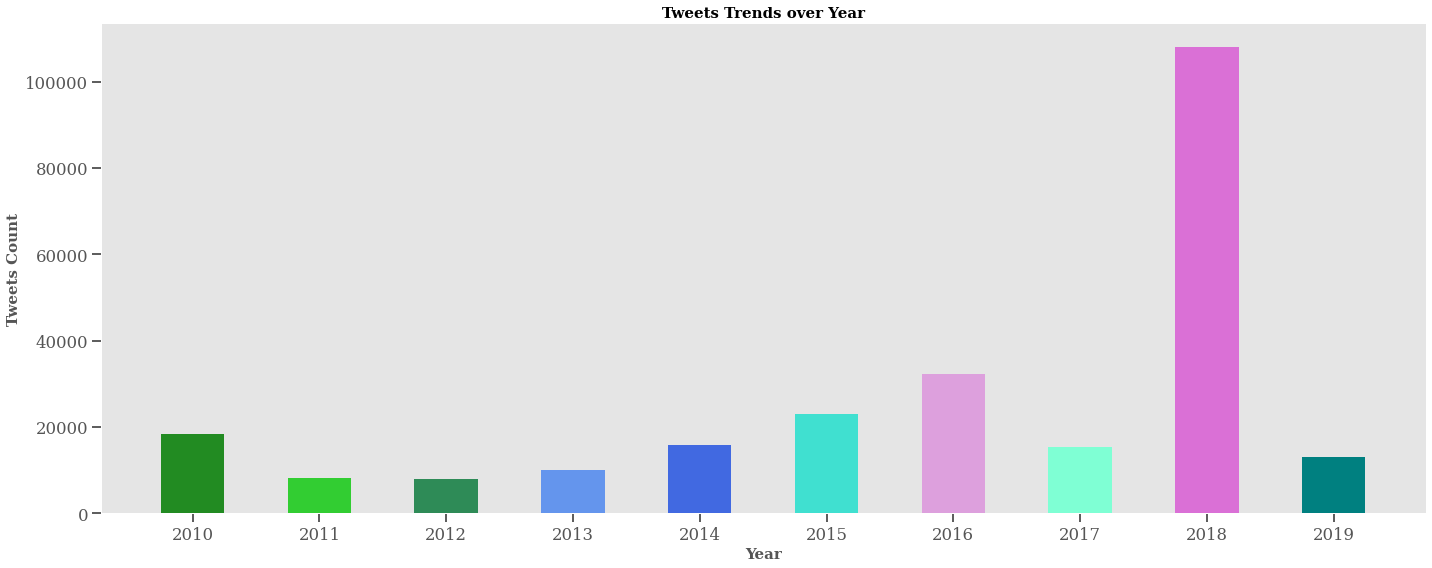

In [83]:

#number of tweets by year
by_year = tweetsDF.groupby(['year']).size().reset_index(name='counts')
by_year = by_year.set_index('year')
by_year.reset_index(level=0,inplace = True,drop=False)
by_year.index += 1
print('Tweets by Year: ')
by_year

colors=['forestgreen','limegreen','seagreen','cornflowerblue','royalblue','turquoise','plum','aquamarine','orchid','teal']
#bar chart tweets by calender date
# by_year_plot = by_year.set_index('year')
# ax = by_year_plot.plot(kind='bar', figsize=(10, 7), color=colors, zorder=2, width=0.5)
# ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on"
#                , left="off", right="off", labelleft="on",labelsize = 12)

height = by_year['counts']
bars = by_year['year']
plt.figure(figsize=(20,8))
plt.bar(bars,height, color=colors, width=0.5)
plt.xticks(bars)
plt.xlabel('Year',fontsize=15, fontweight='bold')
plt.ylabel('Tweets Count',fontsize=15, fontweight='bold')
plt.title('Tweets Trends over Year',fontsize=15, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()

Tweets by Month: 


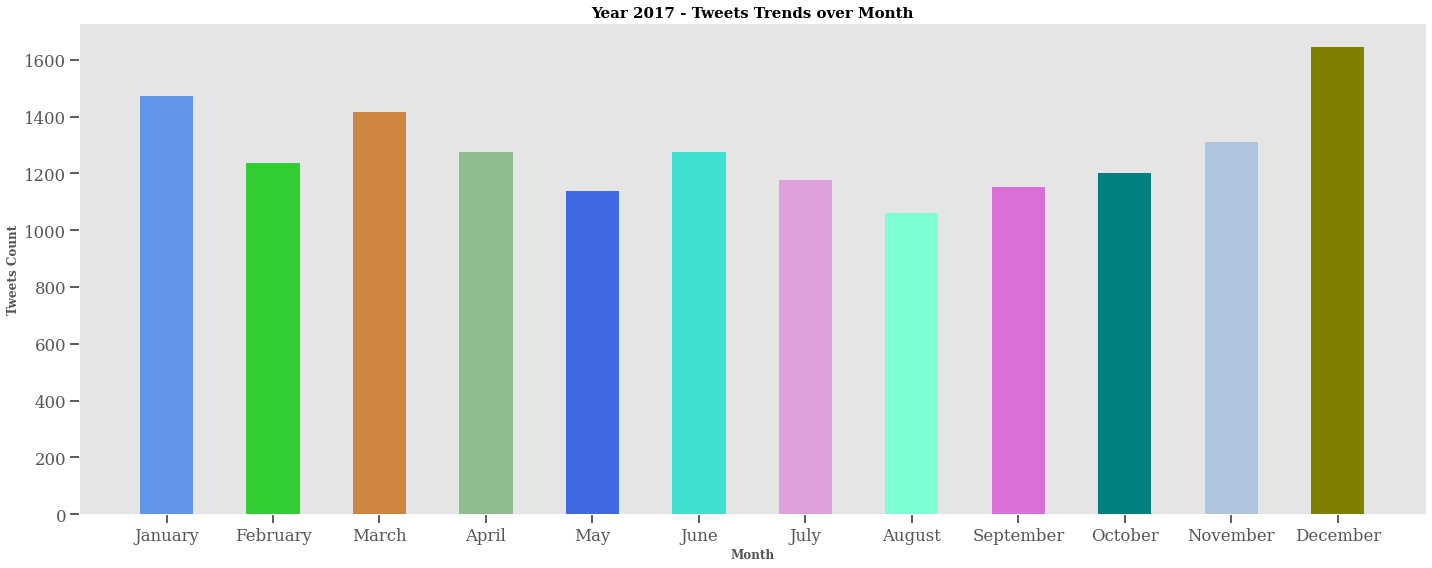

In [84]:

#number of tweets by month in 2017
by_month_2k17= tweetsDF.loc[tweetsDF['year'].isin([2017])]
by_month_2k17 = by_month_2k17.groupby(['monthname','month']).size().reset_index(name='counts')
by_month_2k17 = by_month_2k17.set_index('month')
by_month_2k17.reset_index(level=0,inplace = True,drop=False)
by_month_2k17.index += 1
print('Tweets by Month: ')
by_month_2k17 = by_month_2k17.sort_values('month',ascending=True)

colors=['cornflowerblue','limegreen','peru','darkseagreen','royalblue'
        ,'turquoise','plum','aquamarine','orchid','teal','lightsteelblue','olive']

height = by_month_2k17['counts']
bars = by_month_2k17['monthname']
plt.figure(figsize=(20,8))
plt.bar(bars,height, color=colors, width=0.5)
plt.xticks(bars)
plt.xlabel('Month',fontsize=12, fontweight='bold')
plt.ylabel('Tweets Count',fontsize=12, fontweight='bold')
plt.title('Year 2017 - Tweets Trends over Month',fontsize=15, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()

Tweets by Month: 


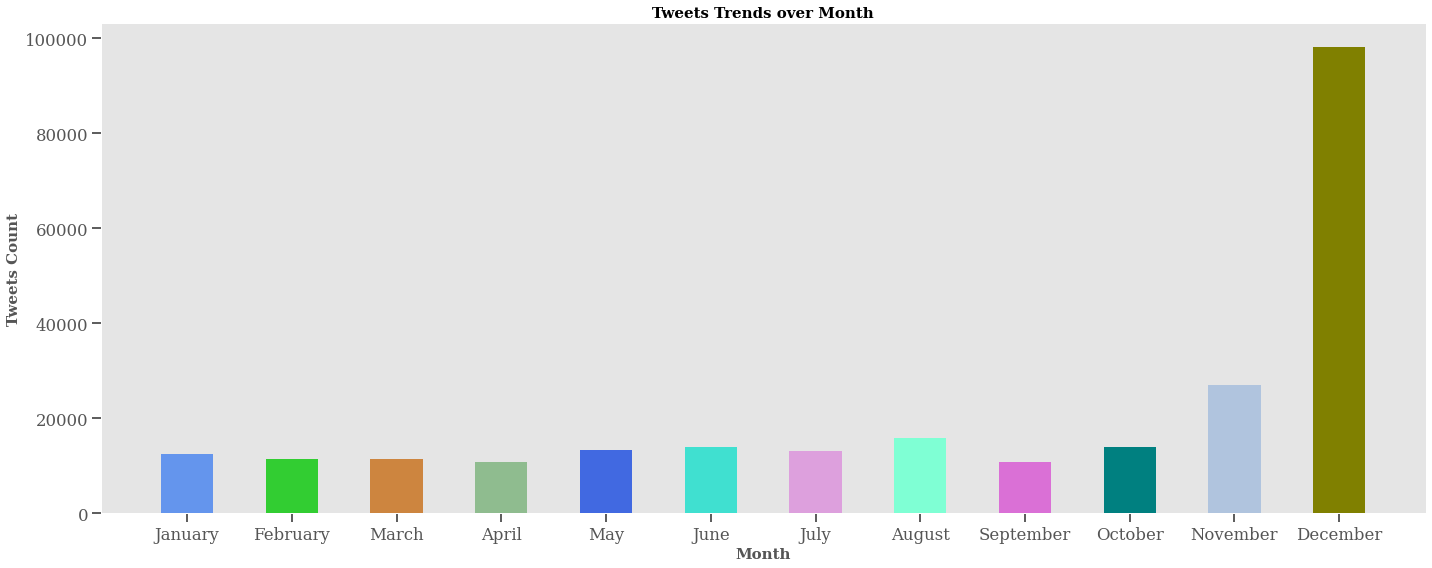

In [85]:
#number of tweets by month
by_month = tweetsDF.groupby(['monthname','month']).size().reset_index(name='counts')
by_month = by_month.set_index('month')
by_month.reset_index(level=0,inplace = True,drop=False)
by_month.index += 1
print('Tweets by Month: ')
by_month = by_month.sort_values('month',ascending=True)

colors=['cornflowerblue','limegreen','peru','darkseagreen','royalblue'
        ,'turquoise','plum','aquamarine','orchid','teal','lightsteelblue','olive']

height = by_month['counts']
bars = by_month['monthname']
plt.figure(figsize=(20,8))
plt.bar(bars,height, color=colors, width=0.5)
plt.xticks(bars)
plt.xlabel('Month',fontsize=15, fontweight='bold')
plt.ylabel('Tweets Count',fontsize=15, fontweight='bold')
plt.title('Tweets Trends over Month',fontsize=15, fontweight='bold')
plt.grid(False)
plt.tight_layout()
plt.show()

In [86]:
# ***********************************************************************************
#       Analyze tweets  and trends for 2017 and 2018
# ***********************************************************************************
tweets_2k17 = tweetsDF.loc[tweetsDF['year'].isin([2017])]
tweets_2k18 = tweetsDF.loc[tweetsDF['year'].isin([2018])]
tweets_2k17_18 = tweetsDF.loc[tweetsDF['year'].isin([2017,2018])]
print('Number of tweets: ',len(tweets_2k17_18))
print('Percentage of tweets {}%'.format(round((len(tweets_2k17_18))/len(tweetsDF['text'])*100,2)))

Number of tweets:  123466
Percentage of tweets 48.91%


In [87]:
# ***********************************************************************************
#       Number of tweets by day
# ***********************************************************************************

#number of tweets by day
tweets_2k17_18_bymonth = tweets_2k17_18.groupby(['year','month','monthname']).size().reset_index(name='counts')
tweets_2k17_18_bymonth = tweets_2k17_18_bymonth.set_index('year','month')
tweets_2k17_18_bymonth.reset_index(level=0,inplace = True,drop=False)
tweets_2k17_18_bymonth.index += 1
print('2017 - 2018 Tweets by Month: ')
tweets_2k17_18_bymonth


2017 - 2018 Tweets by Month: 


,year,month,monthname,counts
1,2017,1,January,1472
2,2017,2,February,1237
3,2017,3,March,1417
4,2017,4,April,1277
5,2017,5,May,1139
6,2017,6,June,1276
7,2017,7,July,1176
8,2017,8,August,1062
9,2017,9,September,1152
10,2017,10,October,1200


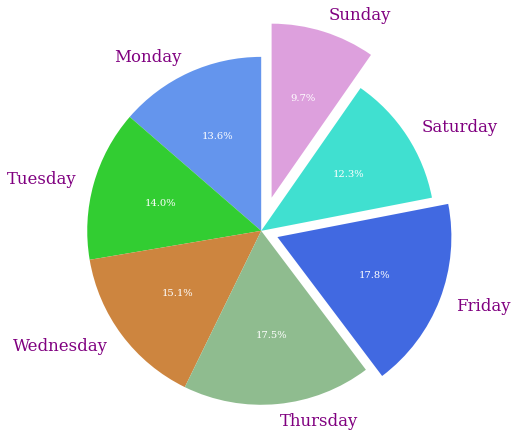

In [88]:
# ***********************************************************************************
#       Analyze tweets trend
# ***********************************************************************************

#number of tweets by day
tweets_2k17_18_byday = tweets_2k17_18.groupby(['weekday','dayname']).size().reset_index(name='counts')
tweets_2k17_18_byday = tweets_2k17_18_byday.set_index('weekday')
tweets_2k17_18_byday.reset_index(level=0,inplace = True,drop=False)
tweets_2k17_18_byday.index += 1
# print('2017 - 2018 Tweets by Week Day: ')
# tweets_2k17_18_byday

# Pie chart

dayname = tweets_2k17_18_byday['dayname']
counts = tweets_2k17_18_byday['counts']
fig, ax = plt.subplots()
colors=['cornflowerblue','limegreen','peru','darkseagreen','royalblue','turquoise','plum']

patches, texts, autotexts = ax.pie(counts, labels = dayname, colors = colors, autopct='%1.1f%%'
                                   , explode=(0,0,0,0,0.2,0,0.4),radius=2,startangle=90)
for text in texts:
    text.set_color('purple')
for autotext in autotexts:
    autotext.set_color('white')

plt.grid(False)
plt.show()


2017 - 2018 Tweets by Week Day: 


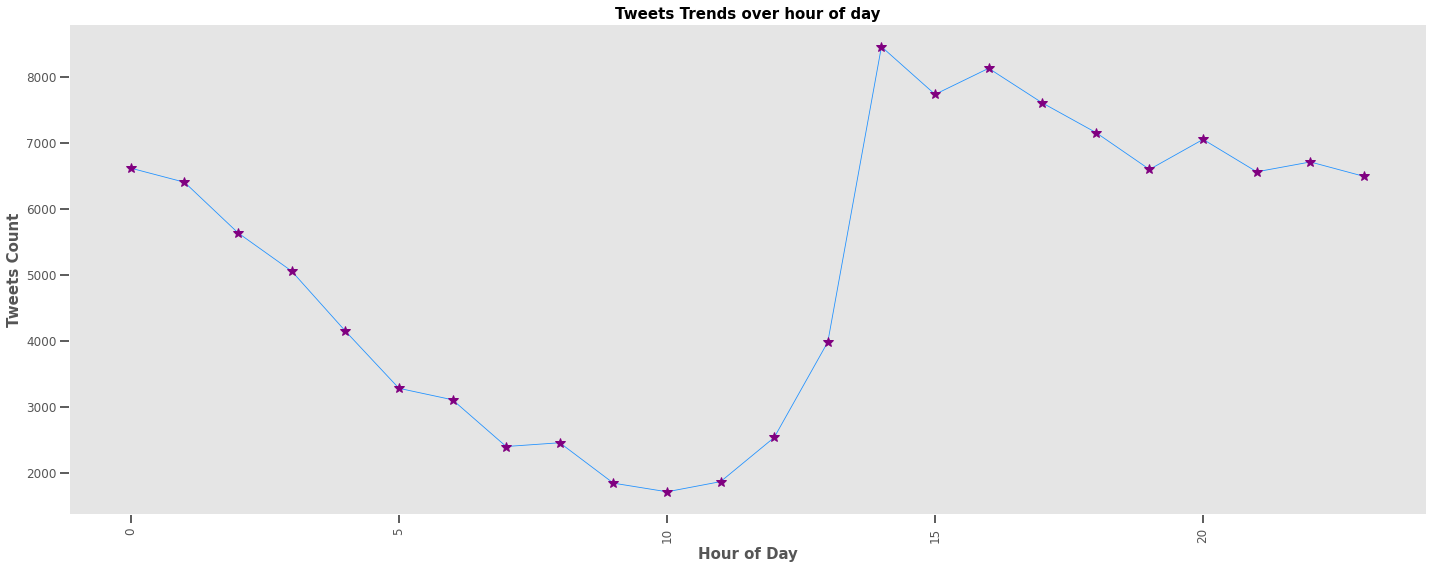

In [89]:
# ***********************************************************************************
#       Analyze tweets trend
# ***********************************************************************************

#number of tweets by hour of day
tweets_2k17_18_byhour = tweets_2k17_18.groupby(['hour']).size().reset_index(name='counts')
tweets_2k17_18_byhour = tweets_2k17_18_byhour.set_index('hour')
tweets_2k17_18_byhour.reset_index(level=0,inplace = True,drop=False)
tweets_2k17_18_byhour.index += 1
print('2017 - 2018 Tweets by Week Day: ')
tweets_2k17_18_byhour

# Theme and styles for visuals
plt.rcParams['font.family'] = "DejaVu Sans" # font
plt.figure(figsize=(20,8))
plt.plot(tweets_2k17_18_byhour.hour, tweets_2k17_18_byhour.counts, linewidth=.8, color ='dodgerblue')
plt.plot(tweets_2k17_18_byhour.hour, tweets_2k17_18_byhour.counts, '*', markersize=10, color='purple')
plt.xticks(fontsize=12, fontweight='regular',rotation=90)
plt.yticks(fontsize=12, fontweight='regular')
plt.xlabel('Hour of Day',fontsize=15, fontweight='bold')
plt.ylabel('Tweets Count',fontsize=15, fontweight='bold')
plt.title('Tweets Trends over hour of day',fontsize=15, fontweight='bold')
plt.grid(False)

plt.tight_layout()



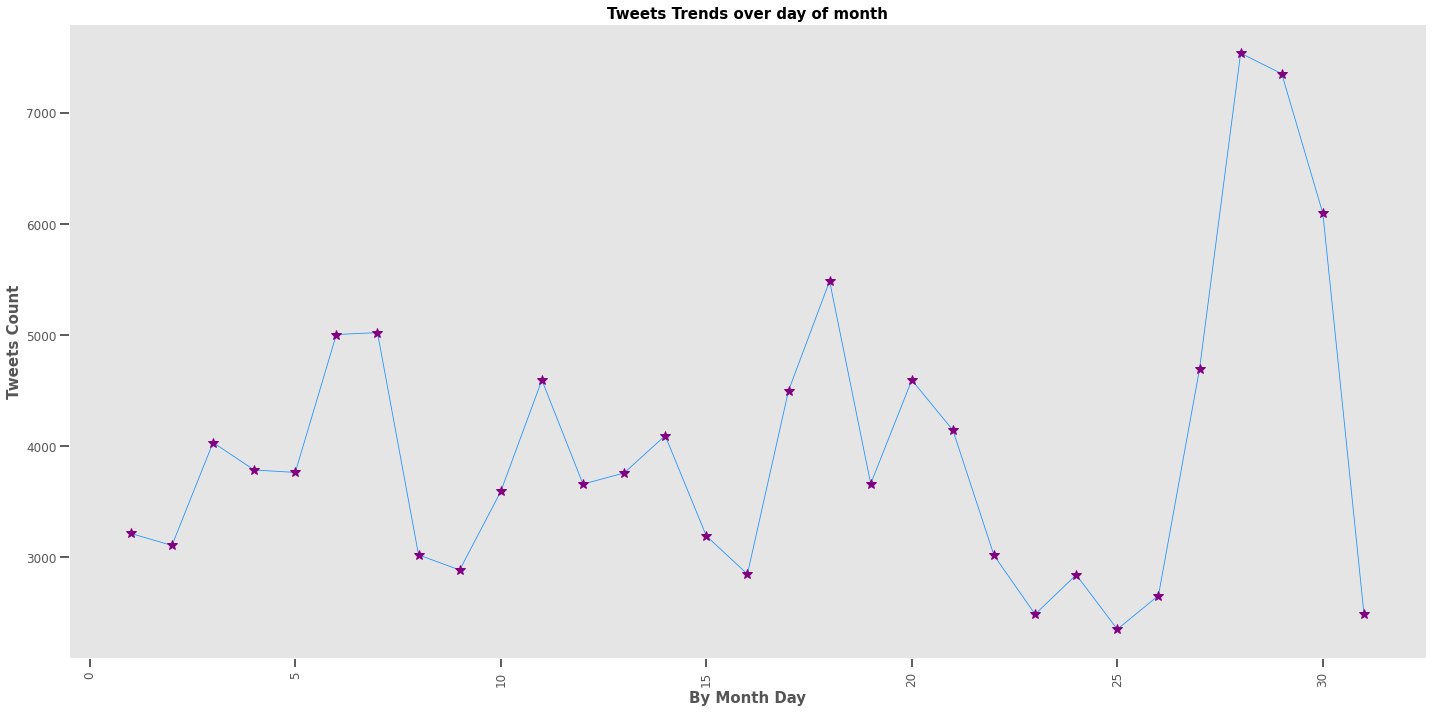

In [90]:
# ***********************************************************************************
#       Analyze tweets trend
# ***********************************************************************************

#number of tweets by hour of day
tweets_2k17_18_byDate = tweets_2k17_18.groupby(['monthday']).size().reset_index(name='counts')
tweets_2k17_18_byDate = tweets_2k17_18_byDate.set_index('monthday')
tweets_2k17_18_byDate.reset_index(level=0,inplace = True,drop=False)
tweets_2k17_18_byDate.index += 1
# print('2017 - 2018 Tweets by Week Day: ')
tweets_2k17_18_byDate

# Theme and styles for visuals
plt.rcParams['font.family'] = "DejaVu Sans" # font
plt.figure(figsize=(20,10))
plt.plot(tweets_2k17_18_byDate.monthday, tweets_2k17_18_byDate.counts, linewidth=.8, color ='dodgerblue')
plt.plot(tweets_2k17_18_byDate.monthday, tweets_2k17_18_byDate.counts, '*', markersize=10, color='purple')
plt.xticks(fontsize=12, fontweight='regular',rotation=90)
plt.yticks(fontsize=12, fontweight='regular')
plt.xlabel('By Month Day',fontsize=15, fontweight='bold')
plt.ylabel('Tweets Count',fontsize=15, fontweight='bold')
plt.title('Tweets Trends over day of month',fontsize=15, fontweight='bold')
plt.grid(False)

plt.tight_layout()




Top 10 | 2017 - 2018 Tweets by Users:

TotalTrafficLA :  16,513
RMRealtor :  2,793
LATrafficInfo :  1,855
smoothjazznola :  1,296
LionelPeyronnet :  891
Bakocom :  843
nme_losangeles :  818
SeeLosAngelesWX :  668
LosAngeles_NC :  643
rrmagazine_ :  540


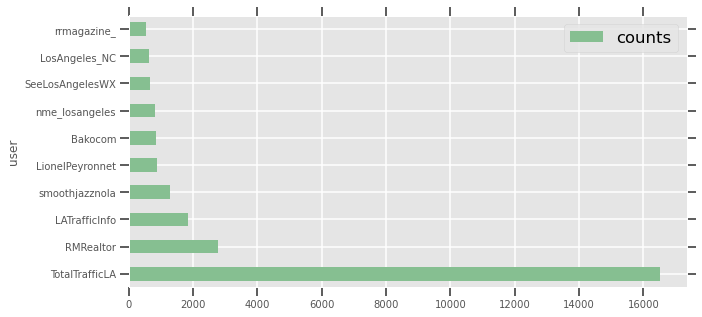

In [91]:
# ***********************************************************************************
#       Analyze tweets trend
# ***********************************************************************************

#number of tweets by users
tweets_2k17_18_byuser = tweets_2k17_18.groupby(['user']).size().reset_index(name='counts')
tweets_2k17_18_byuser = tweets_2k17_18_byuser.set_index('user')
tweets_2k17_18_byuser.reset_index(level=0,inplace = True,drop=False)
tweets_2k17_18_byuser.index += 1
# print('2017 - 2018 Tweets by Users: ')
tweets_2k17_18_byuser

tweets_2k17_18_byuser = tweets_2k17_18_byuser.drop_duplicates().sort_values('counts',ascending=False)
tweets_2k17_18_byuser = tweets_2k17_18_byuser.set_index('user')


tweets_2k17_18_byuser.reset_index(level=0,inplace = True,drop=False)
print('Top 10 | 2017 - 2018 Tweets by Users:\n')
tweets_2k17_18_byuser_top10 = tweets_2k17_18_byuser.head(10)


#print('Top 10 users by tweets: \n')
for index, row in tweets_2k17_18_byuser_top10.iterrows():
    print(row['user'],': ', '{:,.0f}'.format(row["counts"]))
    
# Visualization

tweets_2k17_18_byuser_top10_plot = tweets_2k17_18_byuser_top10.set_index('user')
x = tweets_2k17_18_byuser_top10_plot.plot(kind='barh', figsize=(10, 5), color='#86bf91', zorder=2, width=0.5)

x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on"
               , left="off", right="off", labelleft="on",labelsize = 10)



In [93]:
#number of tweets by date
tweets_2k17_18_byDate = tweets_2k17_18.groupby(['date']).size().reset_index(name='counts')
tweets_2k17_18_byDate = tweets_2k17_18_byDate.set_index('date')
tweets_2k17_18_byDate.reset_index(level=0,inplace = True,drop=False)
tweets_2k17_18_byDate.index += 1
# print('2017 - 2018 Tweets by Users: ')
tweets_2k17_18_byDate

tweets_2k17_18_byDate = tweets_2k17_18_byDate.drop_duplicates().sort_values('counts',ascending=False)
tweets_2k17_18_byDate = tweets_2k17_18_byDate.set_index('date')


tweets_2k17_18_byDate.reset_index(level=0,inplace = True,drop=False)
print('2017 - 2018 | Most Tweets by Date:\n')
tweets_2k17_18_byDate_top10 = tweets_2k17_18_byDate.head(10)


#print('Top 10 users by tweets: \n')
for index, row in tweets_2k17_18_byDate.iterrows():
    print(row['date'],': ', '{:,.0f}'.format(row["counts"]))

2017 - 2018 | Most Tweets by Date:

2018-12-18 :  4,743
2018-11-29 :  4,422
2018-12-07 :  4,354
2018-12-06 :  4,299
2018-12-20 :  3,913
2018-11-28 :  3,886
2018-11-30 :  3,731
2018-12-11 :  3,600
2018-12-03 :  3,485
2018-12-17 :  3,347
2018-12-21 :  3,344
2018-12-14 :  3,336
2018-12-04 :  3,255
2018-12-05 :  3,152
2018-12-19 :  3,063
2018-12-13 :  3,061
2018-12-28 :  3,050
2018-12-12 :  2,931
2018-12-10 :  2,825
2018-12-01 :  2,610
2018-12-15 :  2,480
2018-12-02 :  2,465
2018-12-29 :  2,360
2018-12-08 :  2,359
2018-12-27 :  2,262
2018-12-31 :  2,164
2018-12-22 :  2,155
2018-12-16 :  2,148
2018-12-26 :  2,043
2018-12-24 :  2,040
2018-12-09 :  1,980
2018-12-30 :  1,891
2018-12-23 :  1,798
2018-12-25 :  1,629
2018-11-27 :  1,194
2018-08-27 :  667
2018-08-17 :  544
2018-08-09 :  291
2018-08-11 :  291
2018-08-24 :  238
2017-11-22 :  200
2017-12-07 :  133
2018-11-21 :  133
2017-12-06 :  127
2017-01-25 :  124
2018-11-09 :  104
2017-02-18 :  102
2017-12-05 :  99
2017-12-08 :  97
2018-11-14 :  

In [94]:
#number of tweets by date in 2017
tweets_2k17_byDate = tweets_2k17.groupby(['date']).size().reset_index(name='counts')
tweets_2k17_byDate = tweets_2k17_byDate.set_index('date')
tweets_2k17_byDate.reset_index(level=0,inplace = True,drop=False)
tweets_2k17_byDate.index += 1
# print('2017 - 2018 Tweets by Users: ')
tweets_2k17_18_byDate

tweets_2k17_byDate = tweets_2k17_byDate.drop_duplicates().sort_values('counts',ascending=False)
tweets_2k17_byDate = tweets_2k17_byDate.set_index('date')


tweets_2k17_byDate.reset_index(level=0,inplace = True,drop=False)
print('2017 - 2018 | Most Tweets by Date:\n')
tweets_2k17_byDate_top10 = tweets_2k17_byDate.head(10)


#print('Top 10 users by tweets: \n')
for index, row in tweets_2k17_byDate.iterrows():
    print(row['date'],': ', '{:,.0f}'.format(row["counts"]))

2017 - 2018 | Most Tweets by Date:

2017-11-22 :  200
2017-12-07 :  133
2017-12-06 :  127
2017-01-25 :  124
2017-02-18 :  102
2017-12-05 :  99
2017-12-08 :  97
2017-02-11 :  92
2017-01-12 :  86
2017-10-11 :  80
2017-12-15 :  79
2017-01-20 :  77
2017-12-11 :  75
2017-01-18 :  75
2017-03-24 :  73
2017-02-17 :  71
2017-01-23 :  70
2017-02-02 :  69
2017-10-10 :  69
2017-07-13 :  69
2017-03-11 :  68
2017-06-16 :  68
2017-11-16 :  68
2017-12-12 :  66
2017-10-12 :  66
2017-03-28 :  65
2017-12-02 :  64
2017-06-02 :  64
2017-01-13 :  64
2017-12-22 :  64
2017-12-13 :  63
2017-01-10 :  63
2017-02-08 :  63
2017-07-21 :  62
2017-12-16 :  62
2017-09-28 :  62
2017-11-23 :  62
2017-07-25 :  61
2017-10-06 :  61
2017-04-13 :  61
2017-03-21 :  60
2017-12-20 :  60
2017-06-03 :  60
2017-03-03 :  59
2017-01-27 :  59
2017-03-18 :  59
2017-11-10 :  59
2017-03-08 :  58
2017-04-07 :  58
2017-02-01 :  58
2017-11-14 :  58
2017-02-24 :  58
2017-07-07 :  58
2017-04-25 :  57
2017-09-01 :  56
2017-09-06 :  56
2017-04

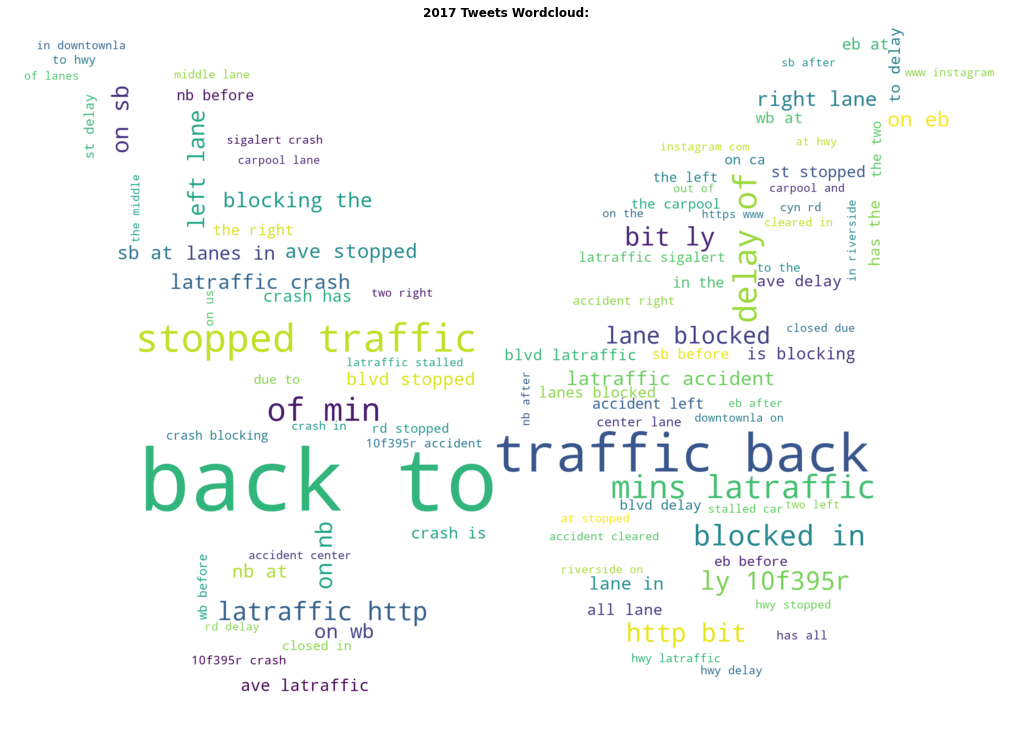

In [97]:
##Wordcloud
tweets = ''
stopwords = set(STOPWORDS)
# Theme and styles for visuals
plt.rcParams['font.family'] = "DejaVu Sans" # font
# sns.set_context('talk') # visuals outputted for presentation style
plt.style.use('ggplot')

# iterate through the csv file 
for val in tweets_2k17.text: 
    # typecaste each val to string 
    val = str(val) 
#     print('text from tweets: ',len(val),'\n',val)
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 

    for words in tokens: 
        tweets = tweets + words + ' '
        
# print('\nWordcloud bag of words from tweets: ',len(tokens),'\n',val)

#update stopwords list
stopwords.update(['https', 'rt','hi','co','promo', 'code','thank','th','ht','latraffic'])

custom_mask = np.array(Image.open("butterfly.png")) #buterfly shape wordcloud

wordcloud = WordCloud(max_words=100,width = 1500, height = 1200,
            background_color ='white',mask=custom_mask,
            stopwords = stopwords).generate(tweets) 

# plot the WordCloud image                        
plt.figure(figsize = (20, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('2017 Tweets Wordcloud: ',fontsize=12, fontweight='bold')
plt.show() 

2017 - Hashtags by Users Wordcloud: 


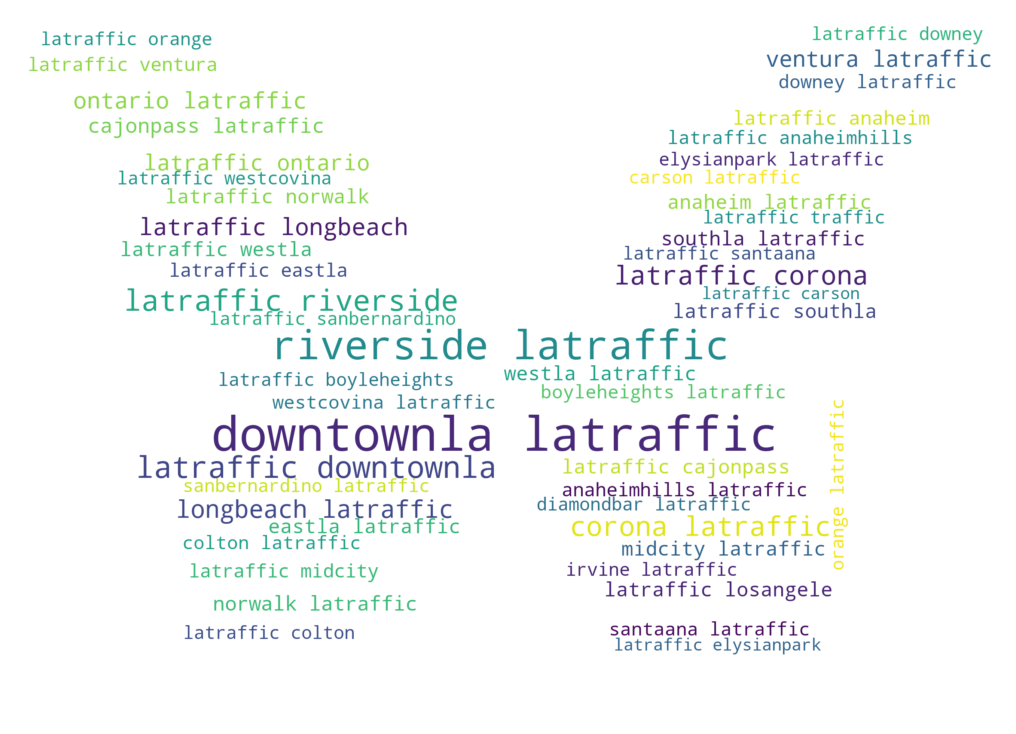

In [98]:
##Wordcloud
tweets = ''
stopwords = set(STOPWORDS)
# Theme and styles for visuals
plt.rcParams['font.family'] = "calibri" # font
# sns.set_context('talk') # visuals outputted for presentation style
plt.style.use('ggplot')

# iterate through the csv file 
for val in tweets_2k17.hashtags: 
    # typecaste each val to string 
    val = str(val) 
#     print('text from tweets: ',len(val),'\n',val)
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 

    for words in tokens: 
        tweets = tweets + words + ' '
        
# print('\nWordcloud bag of words from tweets: ',len(tokens),'\n',val)

#update stopwords list
stopwords.update(['https', 'rt','hi','co','promo', 'code','thank','th','ht','latraffic'])

custom_mask = np.array(Image.open("butterfly.png")) #buterfly shape wordcloud

wordcloud = WordCloud(max_words=50,width = 1500, height = 900,
            background_color ='white',mask=custom_mask,
            stopwords = stopwords).generate(tweets) 

# plot the WordCloud image                        
plt.figure(figsize = (15, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 

print('2017 - Hashtags by Users Wordcloud: ')
plt.show() 

In [99]:
#most trending hashtags - tokenization

from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()
tweet_tokens = []
for sent in tweets_2k17_18['hashtags']:
#     print(tweet_tokenizer.tokenize(sent))
    tweet_tokens.append(tweet_tokenizer.tokenize(sent))
xyz = tweet_tokens
print(len(xyz))
xyz[:5]

123466


[['#morenovalley', '#latraffic'],
 ['#sanbernardino', '#latraffic'],
 ['#valencia', '#latraffic'],
 ['#santaclarita', '#latraffic'],
 ['#victorville', '#latraffic']]

In [100]:
#most trending hashtags

#move to dataframe
hastagsDF = pd.DataFrame(xyz)
hastagsDF.fillna("",inplace=True)
hastagsDF.shape #(123466, 41)
# hastagsDF.info()

hastagsDF1 = hastagsDF.apply(lambda x: x.str.split(expand=True).stack()).stack().value_counts()
hastagsDF1.head(6)

#losangeles    69472
#latraffic     23464
#california    10878
#la             7216
#newyork        5718
#hollywood      4801
dtype: int64